#### Notebook 'Tempo'

In [13]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from itertools import combinations
from collections import Counter
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities


In [14]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['DROGAS_Y_CORRUPCIÓN'],
    'var_1': ['per603'],
    'var_2': ['per604'],
    'var_3': ['per605'],
    'var_4': ['per104'],
    'var_5': ['per304']
}
df_aspectos = pd.DataFrame(data_aspectos)
display(df_aspectos)
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
display(df_AD.head())

,aspecto,var_1,var_2,var_3,var_4,var_5
0,DROGAS_Y_CORRUPCIÓN,per603,per604,per605,per104,per304


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [15]:
# Cargar datasets
df = pd.read_excel('./data/MP_Dataset_KMeans_mean.xlsx')  # Dataset principal
print("Datos cargados:")
display(df.head())


Datos cargados:


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1997,Albania,1.770988,0.00000,0.031388,3.046506,0.015910,0.032313,3.406129,1.114989,...,2.021481,0.0,0.0,0.0,0.0,0.0,0.637892,0.363756,0.0,0.0
1,2001,Albania,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.989546,0.0,0.0,0.0,0.0,0.0,0.897238,0.508457,0.0,0.0
2,1989,Argentina,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,1995,Argentina,0.061642,0.02014,0.143247,0.882433,0.083005,1.107286,1.996025,1.669947,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,1999,Argentina,0.192543,0.00000,0.582363,0.524400,0.017829,0.613450,3.482869,2.262154,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


#### Paso 3: Definición de Funciones

##### Filtrar y Normalizar

In [16]:
def filtrar_normalizar(df_periodo, variables):
    df_filtered = df_periodo[['countryname', 'agno'] + list(variables)].copy()
    df_filtered.dropna(inplace=True)
    columns_per = variables
    df_filtered['per_sum'] = df_filtered[columns_per].sum(axis=1)
    rows_to_normalize = df_filtered['per_sum'] != 1.0
    df_filtered.loc[rows_to_normalize, columns_per] = df_filtered.loc[rows_to_normalize, columns_per].div(
        df_filtered.loc[rows_to_normalize, 'per_sum'], axis=0
    )
    df_filtered.drop(columns=['per_sum'], inplace=True)
    return df_filtered


In [17]:
def preprocesar_periodo(df, desde, hasta):
    """
    Preprocesa el DataFrame para el período seleccionado.
    Combina registros de países con múltiples elecciones en el período y normaliza las variables.
    
    Parámetros:
    - df: DataFrame principal con datos de programas de gobierno.
    - desde: Año inicial del período.
    - hasta: Año final del período.

    Retorna:
    - df_periodo: DataFrame preprocesado con un registro por país en el período.
    """
    # Filtrar el DataFrame para el período
    df_periodo = df[(df['agno'] >= desde) & (df['agno'] <= hasta)]

    # Identificar países con más de una elección en el período
    duplicated_countries = df_periodo['countryname'].value_counts()
    duplicated_countries = duplicated_countries[duplicated_countries > 1]

    if not duplicated_countries.empty:
        print("\nPaíses con más de una elección en el período:")
        for country in duplicated_countries.index:
            print(f"\n{country}:")

            # Filtrar datos del país con duplicados
            country_data = df_periodo[df_periodo['countryname'] == country]

            # Imprimir los registros originales
            print(f"Registros originales ({len(country_data)}):")
            display(country_data)

            # Promediar las columnas `per` y conservar el primer año
            per_columns = [col for col in df_periodo.columns if col.startswith('per')]
            averaged_row = country_data[per_columns].mean().to_dict()
            averaged_row['agno'] = country_data['agno'].min()  # Primer año del período
            averaged_row['countryname'] = country

            # Imprimir los valores promedio
            print("\nValores promediados:")
            for key, value in averaged_row.items():
                if key in per_columns:  # Solo mostrar columnas 'per'
                    print(f"{key}: {value:.4f}")

            # Eliminar los registros originales del dataframe filtrado
            df_periodo = df_periodo[df_periodo['countryname'] != country]

            # Agregar el registro promediado al dataframe
            df_periodo = pd.concat([df_periodo, pd.DataFrame([averaged_row])], ignore_index=True)

    else:
        print("\nNo hay países con más de una elección en el período.")

    # Verificar los resultados finales
    print("\nDataframe ajustado (un registro por país en el período):")
    display(df_periodo)

    return df_periodo


In [18]:
def filtrar_y_normalizar(df_periodo, variables):
    """
    Filtra y normaliza las columnas 'per' en un DataFrame para un período específico.
    Elimina registros con valores NaN o donde todas las columnas 'per' seleccionadas son 0.

    Parámetros:
    - df_periodo: DataFrame ya preprocesado para un período (salida de `preprocesar_periodo`).
    - variables: Lista de columnas 'per' relevantes para el aspecto en análisis.

    Retorna:
    - df_filtered: DataFrame filtrado y normalizado.
    """
    # Filtrar el DataFrame para las columnas seleccionadas
    df_filtered = df_periodo[['countryname', 'agno'] + list(variables)].copy()

    # Identificar registros con valores NaN
    registros_nan = df_filtered[df_filtered[variables].isna().any(axis=1)]
    if not registros_nan.empty:
        print("\nRegistros eliminados por contener valores NaN:")
        display(registros_nan)

    # Eliminar registros con valores NaN
    df_filtered.dropna(inplace=True)

    # Identificar registros con todos los valores en cero
    registros_cero = df_filtered[df_filtered[variables].sum(axis=1) == 0]
    if not registros_cero.empty:
        print("\nRegistros eliminados por tener todas las variables seleccionadas en cero:")
        display(registros_cero)

    # Eliminar registros con todos los valores en cero
    df_filtered = df_filtered[df_filtered[variables].sum(axis=1) > 0]

    # Normalizar las columnas 'per'
    columns_per = variables
    df_filtered['per_sum'] = df_filtered[columns_per].sum(axis=1)
    rows_to_normalize = df_filtered['per_sum'] != 1.0
    df_filtered.loc[rows_to_normalize, columns_per] = df_filtered.loc[rows_to_normalize, columns_per].div(
        df_filtered.loc[rows_to_normalize, 'per_sum'], axis=0
    )
    df_filtered.drop(columns=['per_sum'], inplace=True)

    # Verificar que las variables 'per' sumen 1
    assert df_filtered[columns_per].sum(axis=1).round(6).eq(1).all(), "Error: las variables 'per' no suman 1."

    return df_filtered


##### PCA y K-MEANS

In [19]:
def ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta):
    """
    Ejecuta PCA y K-MEANS, y visualiza los resultados en 2D y 3D con títulos personalizados.
    
    Parámetros:
    - df_filtered: DataFrame filtrado y normalizado.
    - variables: Lista de variables 'per' a incluir en el análisis.
    - aspecto_filtro: Aspecto analizado (str).
    - desde: Año inicial del período.
    - hasta: Año final del período.
    
    Retorna:
    - df_pca: DataFrame con las componentes principales y los clústeres.
    - pca: Objeto PCA ajustado.
    - kmeans: Objeto K-MEANS ajustado.
    """
    # Paso 1: Ejecutar PCA
    numeric_data = df_filtered[variables]
    pca = PCA(n_components=min(len(variables), 3))  # Usar hasta 3 componentes principales
    pca_components = pca.fit_transform(numeric_data)
    
    # Crear DataFrame con las componentes principales
    df_pca = pd.DataFrame(
        pca_components, 
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=df_filtered.index
    )
    df_pca = pd.concat([df_filtered[['countryname', 'agno']], df_pca], axis=1)
    
    # Paso 2: Aplicar K-MEANS
    optimal_k = 3  # Por defecto usamos 3 clústeres (puedes ajustar o calcular dinámicamente)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df_pca['cluster'] = kmeans.fit_predict(df_pca[[f'PC{i+1}' for i in range(pca.n_components_)]])
    
    # Paso 3: Visualizar clústeres en 2D
    plt.figure(figsize=(12, 6))
    for cluster in range(optimal_k):
        cluster_data = df_pca[df_pca['cluster'] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)
    plt.title(f"Clústeres en 2D (PCA)\nAspecto: {aspecto_filtro} | Período: {desde}-{hasta}")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return df_pca, pca, kmeans


##### Matriz de coincidencias

In [20]:
def construir_matriz_coincidencias(resultados_temporales):
    coincidencias = Counter()
    for clusters in resultados_temporales.values():
        for cluster in clusters.values():
            for pair in combinations(sorted(cluster), 2):
                coincidencias[pair] += 1

    # Convertir a matriz
    paises = sorted(set([p for pair in coincidencias.keys() for p in pair]))
    coincidence_matrix = pd.DataFrame(0, index=paises, columns=paises)

    for (p1, p2), count in coincidencias.items():
        coincidence_matrix.loc[p1, p2] = count
        coincidence_matrix.loc[p2, p1] = count

    return coincidence_matrix


##### Visualización del grafo

In [21]:
# from pyvis.network import Network
# import networkx as nx
# from networkx.algorithms.community import greedy_modularity_communities

# def grafo_coincidencias(coincidence_matrix):
#     """
#     Crea un grafo interactivo mejorado a partir de la matriz de coincidencias.
    
#     - Ajusta colores de nodos según las comunidades detectadas.
#     - Modifica el grosor de las líneas según el peso de las conexiones.
#     - Ajusta el tamaño de los nodos según su grado.
#     - Añade una leyenda descriptiva al grafo.
#     """
#     # Crear el grafo de NetworkX
#     G = nx.Graph()
#     for i, row in coincidence_matrix.iterrows():
#         for j, value in row.items():
#             if value > 0:  # Solo conexiones con peso mayor a 0
#                 G.add_edge(i, j, weight=value)

#     # Validar que las aristas tengan el atributo 'weight'
#     for u, v, data in G.edges(data=True):
#         if "weight" not in data:
#             data["weight"] = 1  # Asignar un peso por defecto si no existe

#     # Detectar comunidades usando modularidad
#     communities = list(greedy_modularity_communities(G))
#     community_map = {}
#     for community_index, community_nodes in enumerate(communities):
#         for node in community_nodes:
#             community_map[node] = community_index

#     # Crear un grafo interactivo con PyVis
#     net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
#     net.from_nx(G)

#     # Ajustar nodos y aristas
#     for node in net.nodes:
#         # Color del nodo según la comunidad
#         community = community_map[node["id"]]
#         node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
#         # Tamaño del nodo según el grado
#         node["value"] = len(list(G.neighbors(node["id"])))

#     for edge in net.edges:
#         # Grosor de las aristas según el peso
#         weight = G[edge["from"]][edge["to"]].get("weight", 1)  # Usar un peso por defecto si falta
#         edge["value"] = weight

#     # Añadir una leyenda descriptiva al grafo
#     legend_html = """
#     <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
#         <strong>Leyenda:</strong>
#         <ul style="list-style-type: none; padding-left: 0;">
#             <li><strong>Nodos:</strong> Países</li>
#             <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
#             <li><strong>Color:</strong> Comunidad detectada</li>
#             <li><strong>Aristas:</strong> Coincidencias entre países</li>
#             <li><strong>Grosor:</strong> Peso de la conexión</li>
#         </ul>
#     </div>
#     """
#     net.html += legend_html

#     # Mostrar el grafo
#     net.show("grafo_coincidencias.html")
#     print("Grafo guardado como 'grafo_coincidencias.html'. Ábrelo para visualizar.")


#### Grafo de Trayectorias temporales

#### Gráfico de coincidencias (con un cierto mínimo)

In [22]:
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

def grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10):
    """
    Crea un grafo interactivo mejorado a partir de la matriz de coincidencias,
    filtrando conexiones con menos de `min_coincidencias` coincidencias.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)  # Añadir peso correctamente

    # Detectar comunidades usando modularidad
    communities = list(greedy_modularity_communities(G))
    community_map = {}
    for community_index, community_nodes in enumerate(communities):
        for node in community_nodes:
            community_map[node] = community_index

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad
        community = community_map[node["id"]]
        node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
        # Tamaño del nodo según el grado
        node["value"] = len(list(G.neighbors(node["id"])))

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

    # Guardar el grafo en un archivo HTML
    output_file = "grafo_coincidencias_filtrado.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")
    
    # Agregar la leyenda directamente al archivo HTML
    legend_html = f"""
    <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
        <strong>Leyenda:</strong>
        <ul style="list-style-type: none; padding-left: 0;">
            <li><strong>Nodos:</strong> Países</li>
            <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
            <li><strong>Color:</strong> Comunidad detectada</li>
            <li><strong>Aristas:</strong> Coincidencias entre países</li>
            <li><strong>Grosor:</strong> Peso de la conexión (coincidencias >= {min_coincidencias})</li>
        </ul>
    </div>
    """
    with open(output_file, "r", encoding="utf-8") as file:
        html_content = file.read()
    
    # Insertar la leyenda antes del cierre del body
    html_content = html_content.replace("</body>", legend_html + "\n</body>")
    
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(html_content)

    print("Leyenda añadida al archivo HTML.")


#### Heatmap de coincidencias (con un cierto mínimo)

In [23]:
def heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm"):
    """
    Genera un heatmap mostrando solo los países que tienen coincidencias >= min_coincidencias,
    con las celdas que cumplen mostrando el número real de coincidencias y las que no cumplen en blanco.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para considerar un enlace.
    - cmap: Paleta de colores para el heatmap.
    """
    # Crear una copia de la matriz para no modificar el original
    filtered_matrix = coincidence_matrix.copy()
    
    # Filtrar países que cumplen el umbral en filas o columnas
    relevant_countries = (filtered_matrix >= min_coincidencias).sum(axis=1) > 0
    filtered_matrix = filtered_matrix.loc[relevant_countries, relevant_countries]
    
    # Crear una máscara para ocultar valores por debajo del umbral
    mask = filtered_matrix < min_coincidencias
    
    # Verificar si quedan datos para graficar
    if filtered_matrix.empty:
        print(f"No hay países con coincidencias >= {min_coincidencias}.")
        return
    
    # Crear el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        filtered_matrix,
        annot=filtered_matrix.where(~mask).round(0),  # Mostrar valores enteros redondeados
        fmt="g",  # Usar formato general (float/int)
        cmap=cmap,
        linewidths=0.5,  # Añadir líneas de la grilla
        linecolor="gray",
        cbar_kws={"label": "Número de Coincidencias"},
        mask=mask  # Aplicar la máscara
    )
    plt.title(f"Heatmap de Coincidencias Filtrado (≥ {min_coincidencias})", fontsize=14)
    plt.xlabel("País")
    plt.ylabel("País")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


#### Ejecución para un período

In [ ]:
# Definir el período específico
desde = 2019
hasta = 2022

# Definir las variables asociadas al aspecto de análisis
aspecto_filtro = 'DROGAS_Y_CORRUPCIÓN'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3', 'var_4', 'var_5']].dropna().values.flatten()

# Preprocesar y normalizar los datos del período seleccionado
df_periodo = preprocesar_periodo(df, desde, hasta)
df_filtered = filtrar_y_normalizar(df_periodo, variables)

# Verificar el resultado del DataFrame filtrado
print("\nDataFrame filtrado y normalizado:")
print(df_filtered.info())
display(df_filtered.head())

# Ejecutar y visualizar PCA y K-MEANS
df_pca, pca, kmeans = ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta)



#### Ejecución para Múltiples Períodos


Procesando período: 1949-1951

Países con más de una elección en el período:

Australia:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
20,1949,Australia,2.709164,0.0,0.0,1.740081,0.000000,0.204660,2.053849,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,1951,Australia,1.585687,0.0,0.0,8.248606,1.264054,1.429908,1.264054,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 2.1474
per102: 0.0000
per103: 0.0000
per104: 4.9943
per105: 0.6320
per106: 0.8173
per107: 1.6590
per108: 0.0000
per109: 0.0614
per110: 0.0000
per201: 1.7767
per202: 0.9856
per203: 2.0346
per204: 0.0000
per301: 0.6445
per302: 0.1459
per303: 3.9862
per304: 0.0000
per305: 5.0049
per401: 4.0828
per402: 1.2052
per403: 1.9520
per404: 3.2042
per405: 0.0000
per406: 0.3774
per407: 0.0829
per408: 7.3901
per409: 0.0000
per410: 2.9427
per411: 2.3328
per412: 0.0000
per413: 0.1911
per414: 6.9560
per415: 0.0000
per416: 0.0000
per501: 0.0000
per502: 1.9677
per503: 0.0717
per504: 6.2054
per505: 0.4563
per506: 0.4265
per507: 0.0000
per601: 0.0000
per602: 0.0000
per603: 1.5246
per604: 0.0000
per605: 0.1459
per606: 6.4896
per607: 0.0000
per608: 0.0000
per701: 10.0045
per702: 0.9515
per703: 9.5408
per704: 0.5288
per705: 0.0000
per706: 3.8357
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
10,1949,Israel,0.767385,4.353092,2.965355,11.184192,0.000000,10.46828,6.114075,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1951,Israel,0.946590,0.799253,1.314248,5.146581,0.884416,5.48878,2.524180,0.112326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.8570
per102: 2.5762
per103: 2.1398
per104: 8.1654
per105: 0.4422
per106: 7.9785
per107: 4.3191
per108: 0.0562
per109: 0.1183
per110: 0.0000
per201: 3.6301
per202: 2.4878
per203: 0.8687
per204: 0.8438
per301: 0.1908
per302: 0.0000
per303: 2.5750
per304: 2.7370
per305: 0.6794
per401: 0.8805
per402: 1.5064
per403: 1.8787
per404: 1.5411
per405: 0.0000
per406: 1.2853
per407: 0.0000
per408: 2.1492
per409: 0.0000
per410: 2.2988
per411: 1.3894
per412: 1.5640
per413: 0.3659
per414: 0.5133
per415: 0.0000
per416: 0.0000
per501: 0.0000
per502: 0.4052
per503: 3.9685
per504: 1.2888
per505: 0.0000
per506: 1.8902
per507: 0.0000
per601: 8.7077
per602: 0.0000
per603: 2.7685
per604: 0.0000
per605: 0.0365
per606: 1.1292
per607: 0.4646
per608: 0.1458
per701: 2.8334
per702: 0.1158
per703: 1.3434
per704: 1.2161
per705: 0.8819
per706: 1.9094
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
12,1949,New Zealand,1.501770,0.092198,0.0,1.132453,0.0,0.000000,1.880605,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1951,New Zealand,2.543331,0.260205,0.0,2.962228,0.0,0.361259,1.084236,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 2.0226
per102: 0.1762
per103: 0.0000
per104: 2.0473
per105: 0.0000
per106: 0.1806
per107: 1.4824
per108: 0.0000
per109: 0.0000
per110: 0.0000
per201: 0.3192
per202: 0.3696
per203: 0.2687
per204: 0.0461
per301: 0.7392
per302: 0.0925
per303: 1.2934
per304: 0.0461
per305: 1.4523
per401: 1.7242
per402: 7.6094
per403: 1.5783
per404: 5.4944
per405: 0.0000
per406: 1.2943
per407: 0.2310
per408: 1.8181
per409: 0.0000
per410: 5.7047
per411: 4.8126
per412: 0.0000
per413: 0.4076
per414: 4.7120
per415: 0.0000
per416: 0.0000
per501: 0.1578
per502: 0.5925
per503: 1.0133
per504: 12.8646
per505: 0.0000
per506: 5.9520
per507: 0.0000
per601: 4.2623
per602: 0.0000
per603: 0.3696
per604: 0.7803
per605: 1.1499
per606: 1.3485
per607: 0.8192
per608: 0.0000
per701: 2.0360
per702: 1.7538
per703: 6.9810
per704: 0.3615
per705: 0.0000
per706: 11.4165
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023:

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
16,1950,United Kingdom,2.242908,0.352146,0.975010,0.220091,0.247804,1.323927,2.072338,1.134173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1951,United Kingdom,3.611436,0.431553,0.392959,2.267130,0.431553,2.353934,4.302720,0.038594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 2.9272
per102: 0.3918
per103: 0.6840
per104: 1.2436
per105: 0.3397
per106: 1.8389
per107: 3.1875
per108: 0.5864
per109: 0.1761
per110: 0.1100
per201: 0.7133
per202: 1.4407
per203: 0.8293
per204: 0.1989
per301: 1.5843
per302: 0.4842
per303: 0.7671
per304: 0.1761
per305: 0.6603
per401: 1.0839
per402: 0.8089
per403: 2.5340
per404: 2.4135
per405: 0.0660
per406: 0.5445
per407: 0.2600
per408: 4.6912
per409: 1.5666
per410: 1.9838
per411: 0.9213
per412: 2.1512
per413: 4.0658
per414: 1.1921
per415: 0.0000
per416: 0.0000
per501: 0.0935
per502: 0.6174
per503: 3.1342
per504: 3.3155
per505: 0.0799
per506: 1.6262
per507: 0.0799
per601: 2.4721
per602: 0.1761
per603: 0.2038
per604: 0.0000
per605: 0.1293
per606: 1.1291
per607: 0.3714
per608: 0.0660
per701: 1.7234
per702: 0.6448
per703: 3.1172
per704: 2.0237
per705: 1.2396
per706: 0.9701
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
1,1949,Belgium,2.949463,0.0,0.0,2.150880,0.0,0.829758,2.194157,0.907074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1950,Belgium,2.484151,0.0,0.0,2.333902,0.0,1.268892,2.289464,1.018477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 2.7168
per102: 0.0000
per103: 0.0000
per104: 2.2424
per105: 0.0000
per106: 1.0493
per107: 2.2418
per108: 0.9628
per109: 0.0000
per110: 0.0000
per201: 2.6514
per202: 1.9347
per203: 0.7125
per204: 0.6436
per301: 2.9605
per302: 0.0000
per303: 2.1454
per304: 0.0000
per305: 0.0000
per401: 3.0788
per402: 1.3296
per403: 0.2818
per404: 1.7074
per405: 0.0000
per406: 0.6949
per407: 0.0000
per408: 1.7145
per409: 0.0000
per410: 2.1773
per411: 1.4752
per412: 0.0672
per413: 0.1008
per414: 2.8582
per415: 0.0000
per416: 0.0000
per501: 0.1074
per502: 0.6381
per503: 7.9929
per504: 10.4944
per505: 0.1292
per506: 1.7781
per507: 0.2482
per601: 1.0975
per602: 0.0000
per603: 2.3235
per604: 0.0336
per605: 0.2482
per606: 1.1586
per607: 2.8564
per608: 0.5818
per701: 3.3720
per702: 0.0000
per703: 6.0422
per704: 6.4849
per705: 2.2326
per706: 8.1942
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1949,Austria,2.753253,4.182441,0.000000,0.839487,0.000000,0.820649,4.590842,0.697073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1949,Canada,1.309533,0.138809,0.055524,1.857265,0.000000,0.166571,0.791751,0.373064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1950,Denmark,2.585329,1.853988,0.083077,3.859698,0.642908,2.486657,1.213645,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1951,Finland,1.736620,0.194392,0.194392,0.000000,2.526655,3.624769,0.539855,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1951,France,7.110845,0.000000,1.081120,3.270059,2.172853,4.041447,3.280307,1.276674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1949,Germany,1.151948,2.472702,0.000000,0.120293,0.291606,0.207928,0.069289,1.082162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1949,Iceland,0.148761,0.000000,0.799172,0.765330,0.233904,0.000000,1.522276,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1951,Ireland,0.000000,3.576199,0.000000,0.511789,0.000000,0.035865,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1951,Luxembourg,1.749359,0.106656,0.000000,0.354255,0.852575,1.450064,0.775809,1.062765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1949,Mexico,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


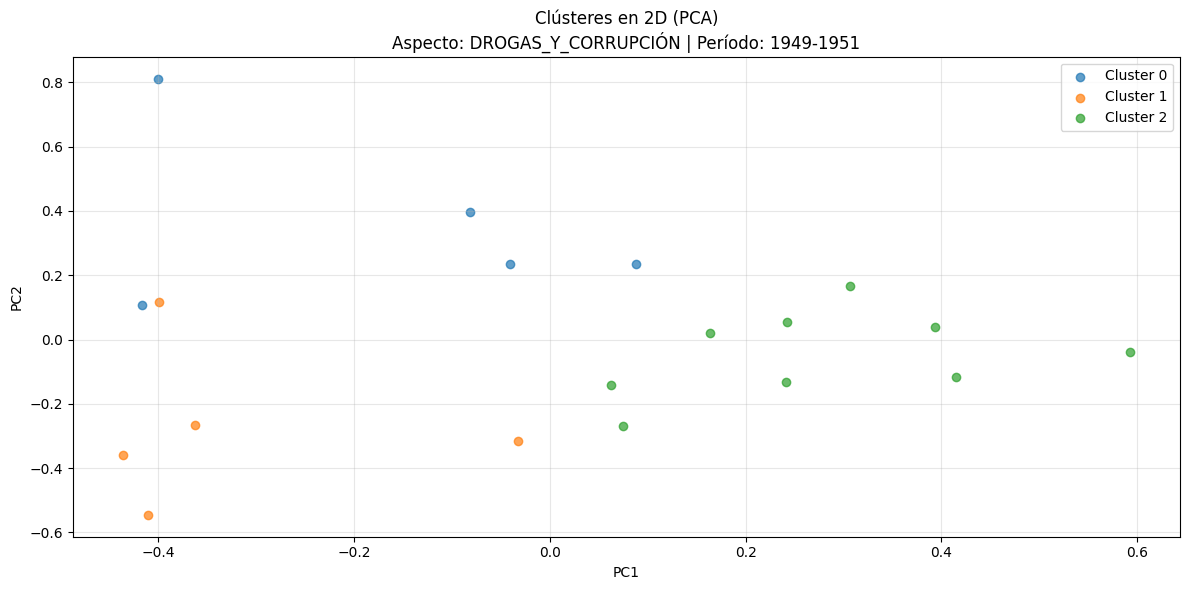


Procesando período: 1952-1954

No hay países con más de una elección en el período.

Dataframe ajustado (un registro por país en el período):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
22,1954,Australia,1.781468,0.000000,0.000000,3.240267,0.000000,0.000000,0.516109,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,1953,Austria,0.592064,4.018195,0.000000,0.150918,0.000000,0.699909,4.812804,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,1954,Belgium,1.387368,0.067757,0.606575,2.117940,1.284861,1.988834,1.847932,3.188931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,1953,Canada,1.385197,1.061547,0.140297,1.686170,0.000000,0.552264,2.844327,0.023383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,1953,Denmark,1.885891,1.108464,0.177344,1.542761,1.965828,1.270620,0.786793,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212,1954,Finland,3.348831,0.511979,0.000000,0.000000,0.000000,1.972573,0.712428,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,1953,Germany,3.020712,0.555393,0.000000,0.826984,0.437284,1.161031,0.041421,2.715646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,1953,Iceland,0.209951,0.000000,0.000000,1.360232,2.294563,0.120344,0.581862,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319,1954,Ireland,0.000000,0.949463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354,1953,Italy,0.040597,0.000000,0.000000,0.046263,1.741071,2.775969,2.280754,0.177133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Registros eliminados por tener todas las variables seleccionadas en cero:


,countryname,agno,per603,per604,per605,per104,per304
509,Northern Ireland,1953,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


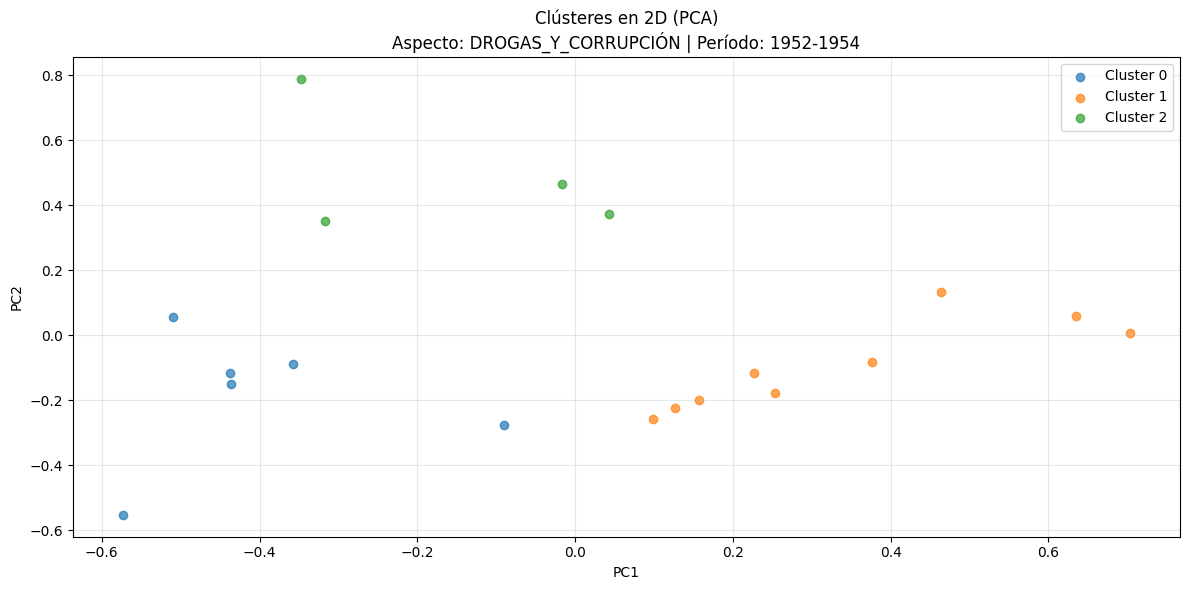


Procesando período: 1955-1957

No hay países con más de una elección en el período.

Dataframe ajustado (un registro por país en el período):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
23,1955,Australia,2.333347,1.145174,0.000000,5.162274,2.244540,0.987641,4.251834,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,1956,Austria,9.222545,1.757454,0.000000,0.000000,0.000000,0.286677,3.054471,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,1957,Canada,0.696358,1.921406,0.154318,0.242665,0.000000,0.363750,0.970165,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,1957,Denmark,0.985192,0.783010,0.000000,2.953631,1.054523,1.124009,0.140678,0.729673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232,1956,France,4.987367,0.000000,0.859979,0.586433,0.605964,3.275949,1.735068,1.443173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
258,1957,Germany,4.783425,1.003888,0.000000,3.298744,6.580846,1.244326,0.502114,3.499646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,1956,Iceland,0.000000,0.000000,0.000000,0.391137,1.148395,0.000000,0.591977,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320,1957,Ireland,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337,1955,Israel,0.619814,0.509120,0.172427,4.741036,0.000000,2.811568,4.118826,0.057476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421,1955,Mexico,0.000000,0.000000,0.000000,0.318415,0.000000,0.318415,2.227996,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Registros eliminados por tener todas las variables seleccionadas en cero:


,countryname,agno,per603,per604,per605,per104,per304
621,Sri Lanka,1956,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


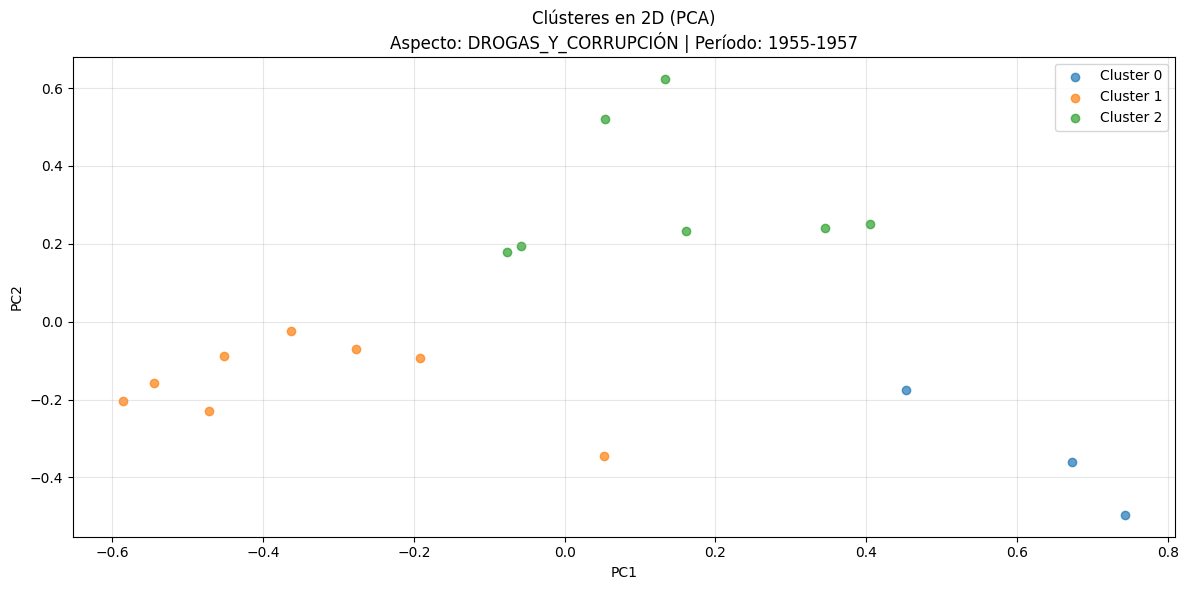


Procesando período: 1958-1960

Países con más de una elección en el período:

Sweden:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
630,1958,Sweden,0.0,0.000000,0.0,0.465620,0.710892,0.818429,0.913026,0.364293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
631,1960,Sweden,0.0,0.385101,0.0,0.610296,0.425812,3.098696,1.091045,0.385101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.0000
per102: 0.1926
per103: 0.0000
per104: 0.5380
per105: 0.5684
per106: 1.9586
per107: 1.0020
per108: 0.3747
per109: 0.1196
per110: 0.0000
per201: 1.3564
per202: 0.4778
per203: 0.0817
per204: 0.0409
per301: 2.4830
per302: 0.0000
per303: 0.8103
per304: 0.0000
per305: 0.0000
per401: 2.8665
per402: 5.3536
per403: 1.3461
per404: 0.1189
per405: 0.0000
per406: 0.5214
per407: 0.2334
per408: 1.2524
per409: 0.4382
per410: 1.0118
per411: 1.7636
per412: 0.3731
per413: 0.0269
per414: 9.4882
per415: 0.0000
per416: 0.0000
per501: 0.0320
per502: 0.5464
per503: 2.2538
per504: 21.3379
per505: 1.9741
per506: 6.2660
per507: 0.1464
per601: 0.0000
per602: 0.0000
per603: 1.7193
per604: 0.0000
per605: 0.4652
per606: 0.2312
per607: 1.0414
per608: 0.0000
per701: 0.0693
per702: 0.0000
per703: 3.5806
per704: 0.0000
per705: 0.0000
per706: 2.8565
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1958,Australia,1.976904,0.484675,0.257004,5.018276,0.969350,0.597283,3.637536,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1959,Austria,0.800952,1.779264,0.000000,0.572847,0.000000,1.493279,1.803608,2.589731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1958,Belgium,3.876299,0.467157,0.485261,0.670117,1.775762,0.793511,1.084048,0.845470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1958,Canada,3.091937,0.054661,0.000000,1.361142,0.000000,1.083393,1.527618,0.135293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1960,Denmark,0.178010,0.091226,0.000000,0.961590,1.234695,2.165913,2.242690,1.352234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1958,Finland,4.065660,0.173358,0.000000,0.059135,0.173358,1.599818,0.899208,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1958,France,5.457686,0.886299,1.637885,0.897245,2.412699,5.032113,0.945652,1.958633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1959,Iceland,0.000000,0.000000,0.000000,0.187581,0.675179,0.000000,2.062587,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1959,Israel,1.558185,0.969346,0.108260,1.877848,1.415042,3.793810,3.508926,0.036087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1958,Italy,0.042313,0.000000,0.260049,1.457808,1.053264,4.563270,2.117512,1.887636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


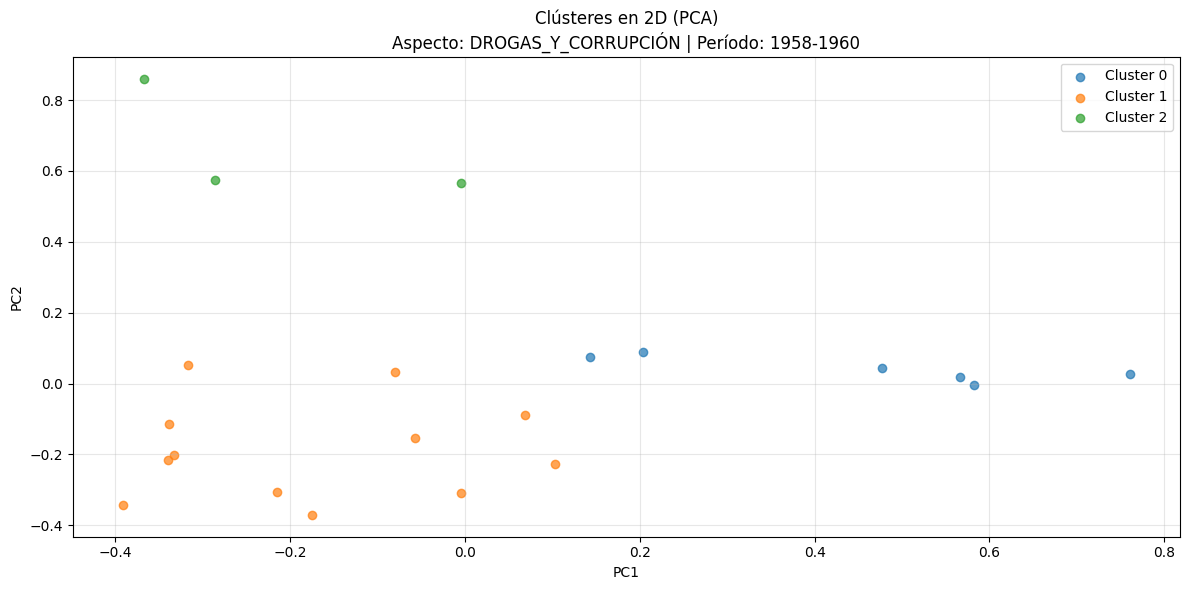


Procesando período: 1961-1963

Países con más de una elección en el período:

Australia:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
25,1961,Australia,3.031917,0.000000,0.000000,2.171919,0.0,0.0,1.734048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,1963,Australia,5.200198,0.030085,0.097778,6.296241,0.0,0.0,4.521745,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 4.1161
per102: 0.0150
per103: 0.0489
per104: 4.2341
per105: 0.0000
per106: 0.0000
per107: 3.1279
per108: 0.0000
per109: 0.4960
per110: 0.0000
per201: 0.1003
per202: 2.7112
per203: 0.2236
per204: 0.0000
per301: 0.9995
per302: 0.0000
per303: 0.7673
per304: 0.0000
per305: 6.4279
per401: 2.6064
per402: 10.2760
per403: 0.8124
per404: 1.8560
per405: 0.0000
per406: 2.0115
per407: 0.2583
per408: 2.4890
per409: 0.0000
per410: 2.8200
per411: 4.6613
per412: 0.0000
per413: 0.0000
per414: 5.8662
per415: 0.0000
per416: 0.0000
per501: 0.3361
per502: 0.0000
per503: 0.0150
per504: 4.1312
per505: 0.0000
per506: 6.2518
per507: 0.0000
per601: 0.2723
per602: 0.0000
per603: 0.0489
per604: 0.0000
per605: 0.0000
per606: 3.4445
per607: 0.0000
per608: 0.0000
per701: 10.4757
per702: 0.0000
per703: 12.7319
per704: 0.0000
per705: 0.0000
per706: 1.1687
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
2,1962,Canada,0.678909,0.013535,0.013535,2.156088,0.0,5.963919,2.197194,0.142385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1963,Canada,1.711146,0.000000,0.000000,6.418320,0.0,2.362713,2.491611,0.125654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 1.1950
per102: 0.0068
per103: 0.0068
per104: 4.2872
per105: 0.0000
per106: 4.1633
per107: 2.3444
per108: 0.1340
per109: 0.0000
per110: 0.0000
per201: 0.7685
per202: 0.9822
per203: 0.0000
per204: 0.0000
per301: 5.9373
per302: 1.4654
per303: 1.3317
per304: 0.7145
per305: 0.2969
per401: 1.5580
per402: 7.6671
per403: 0.7965
per404: 2.8405
per405: 0.4638
per406: 1.5242
per407: 0.3668
per408: 2.8662
per409: 2.4185
per410: 5.3007
per411: 6.6055
per412: 0.3416
per413: 0.0271
per414: 1.4686
per415: 0.0000
per416: 0.0000
per501: 1.2224
per502: 0.6518
per503: 2.4939
per504: 8.7197
per505: 0.1375
per506: 0.2327
per507: 0.0000
per601: 0.4528
per602: 0.0000
per603: 0.2407
per604: 0.0000
per605: 0.0351
per606: 0.0068
per607: 1.6557
per608: 1.5092
per701: 1.3310
per702: 0.0000
per703: 8.1055
per704: 0.1321
per705: 0.1997
per706: 7.1562
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1962,Austria,0.585186,1.170372,0.000000,0.659281,0.912144,1.046250,3.656623,1.695141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1961,Belgium,0.077134,0.023155,1.275243,0.305180,1.831860,0.000000,0.792318,3.818351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1962,Finland,2.663968,0.000000,0.000000,0.000000,1.937390,1.845195,0.559843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1962,France,2.310400,0.000000,1.385322,1.116093,1.570279,2.285193,1.674274,1.962137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1961,Germany,5.800360,2.040600,0.000000,3.924717,1.914137,0.000000,3.283657,1.690999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1963,Iceland,0.085397,0.000000,0.085397,1.133104,1.424109,0.496074,1.704416,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1961,Ireland,0.000000,2.060292,0.213134,0.000000,0.000000,0.000000,0.000000,2.868800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1961,Israel,0.283819,1.875808,0.000000,15.118333,0.000000,0.352424,2.933433,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1963,Italy,0.003092,0.000000,0.221976,1.305763,0.891549,1.253486,1.157232,2.129905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1963,Japan,3.104813,1.400255,0.000000,1.225931,3.186430,3.685428,2.482654,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


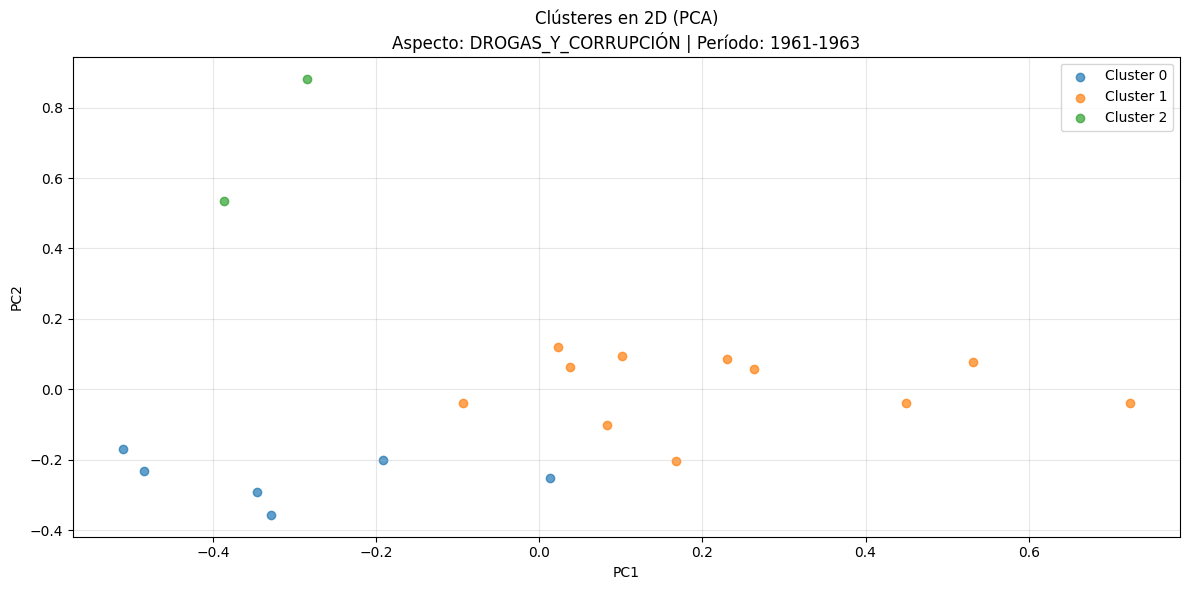


Procesando período: 1964-1966

Países con más de una elección en el período:

United Kingdom:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
697,1964,United Kingdom,1.159908,0.190050,0.483484,1.898128,0.102144,3.180279,5.373561,0.870851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
698,1966,United Kingdom,1.719162,0.585483,0.680616,0.780644,1.335603,0.864720,3.531476,1.924601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 1.4395
per102: 0.3878
per103: 0.5821
per104: 1.3394
per105: 0.7189
per106: 2.0225
per107: 4.4525
per108: 1.3977
per109: 0.4939
per110: 0.0976
per201: 1.3969
per202: 1.0905
per203: 0.5181
per204: 0.1464
per301: 2.4309
per302: 0.3202
per303: 2.5883
per304: 0.1423
per305: 1.0576
per401: 1.6040
per402: 1.2262
per403: 1.1416
per404: 1.2122
per405: 0.0000
per406: 0.3319
per407: 0.3792
per408: 3.1818
per409: 0.1415
per410: 1.5568
per411: 4.1373
per412: 0.8207
per413: 0.8252
per414: 2.1402
per415: 0.0000
per416: 0.0000
per501: 1.9250
per502: 2.2381
per503: 3.5409
per504: 7.6122
per505: 0.5126
per506: 3.4874
per507: 0.3290
per601: 1.1895
per602: 0.1952
per603: 0.2377
per604: 0.0000
per605: 1.5324
per606: 1.1535
per607: 0.0425
per608: 0.0000
per701: 1.2695
per702: 0.7556
per703: 2.2299
per704: 0.9941
per705: 0.4990
per706: 1.9834
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
4,1964,Denmark,1.163316,0.200054,0.000000,1.001704,1.599638,1.139989,1.729993,0.886620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1966,Denmark,1.443581,0.459047,0.037298,0.095944,1.391537,1.208367,1.085598,0.906864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 1.3034
per102: 0.3296
per103: 0.0186
per104: 0.5488
per105: 1.4956
per106: 1.1742
per107: 1.4078
per108: 0.8967
per109: 0.0943
per110: 0.5611
per201: 2.2342
per202: 0.4788
per203: 0.0912
per204: 0.0000
per301: 1.0842
per302: 0.1980
per303: 1.7959
per304: 0.0000
per305: 0.6365
per401: 4.9765
per402: 1.4530
per403: 1.6097
per404: 0.0382
per405: 0.0612
per406: 0.0000
per407: 0.6714
per408: 3.2815
per409: 0.2320
per410: 5.0039
per411: 2.2695
per412: 0.7113
per413: 0.2776
per414: 2.8134
per415: 0.0000
per416: 0.0000
per501: 0.1385
per502: 1.3952
per503: 4.9927
per504: 5.0431
per505: 0.1102
per506: 2.4683
per507: 0.0000
per601: 0.2588
per602: 0.0000
per603: 0.4819
per604: 0.0067
per605: 0.2851
per606: 0.1783
per607: 0.0000
per608: 0.0000
per701: 0.5311
per702: 0.2953
per703: 2.2002
per704: 1.7960
per705: 0.7881
per706: 4.8129
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1966,Australia,3.006210,1.047014,0.457485,9.030630,0.000000,1.211767,3.646658,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1966,Austria,0.139014,0.939556,0.000000,1.687893,0.442156,0.147355,2.025396,1.810397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1965,Belgium,0.568799,0.056508,0.777757,2.267729,0.979854,0.183801,0.365364,1.853053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1965,Canada,0.303720,0.000000,0.206501,1.846780,0.000000,0.128329,0.598849,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1966,Finland,1.202358,0.000000,0.000000,0.000000,1.480492,1.505785,1.904782,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1965,Germany,9.107959,1.393901,0.000000,1.928386,0.418171,1.812692,1.323660,4.575641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1965,Ireland,0.243513,1.092790,0.069633,0.000000,0.000000,0.243513,1.245539,0.535729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1965,Israel,0.694722,0.912503,0.536148,4.578744,0.850471,5.124266,4.178525,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1964,Luxembourg,2.638015,0.171667,0.056403,0.834093,1.797429,1.230195,0.607553,5.222150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1964,Mexico,0.000000,0.000000,0.529548,0.000000,1.675777,2.691752,3.302051,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


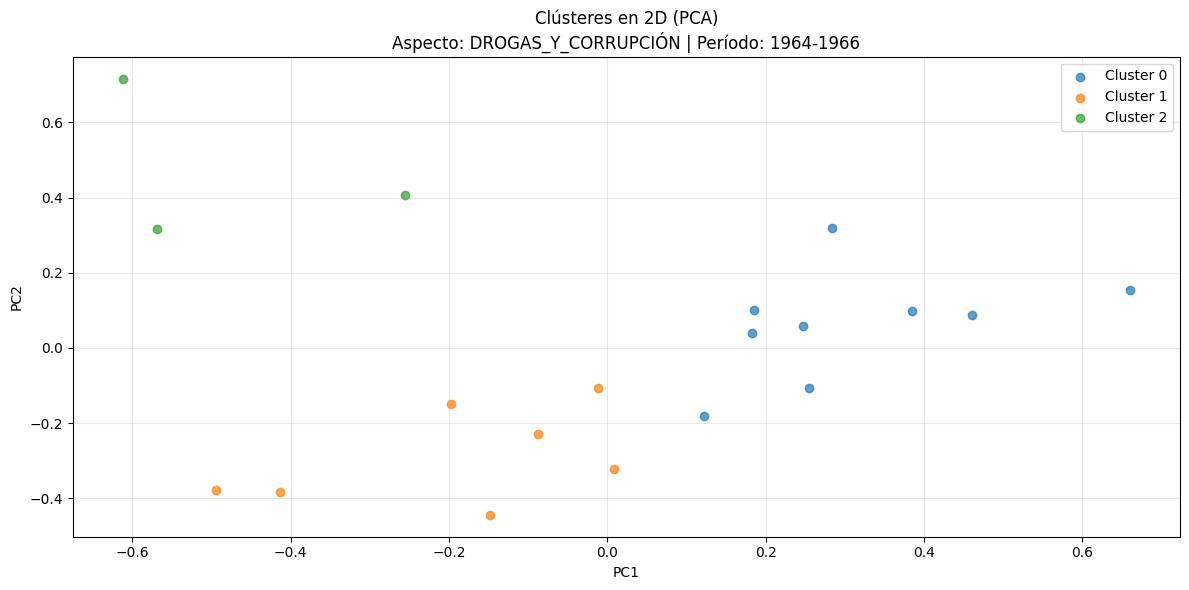


Procesando período: 1967-1969

Países con más de una elección en el período:

Japan:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
369,1967,Japan,5.500305,2.885496,0.747806,2.887095,4.027856,8.107091,7.708523,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,1969,Japan,2.451115,2.407905,0.000000,1.108600,5.202714,2.111791,1.186527,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 3.9757
per102: 2.6467
per103: 0.3739
per104: 1.9978
per105: 4.6153
per106: 5.1094
per107: 4.4475
per108: 0.0000
per109: 0.1170
per110: 0.0000
per201: 2.0523
per202: 5.4083
per203: 2.4809
per204: 0.0000
per301: 0.0000
per302: 0.0000
per303: 0.0000
per304: 3.6879
per305: 3.4267
per401: 0.0000
per402: 9.5687
per403: 4.2111
per404: 1.1109
per405: 0.0000
per406: 0.3806
per407: 0.0000
per408: 0.2123
per409: 0.3107
per410: 3.1427
per411: 6.2471
per412: 5.3106
per413: 0.2382
per414: 0.6900
per415: 0.0000
per416: 0.0000
per501: 1.1323
per502: 0.6928
per503: 6.0576
per504: 4.3489
per505: 0.0000
per506: 3.6277
per507: 0.0000
per601: 0.0000
per602: 0.0000
per603: 0.0000
per604: 0.0000
per605: 3.2333
per606: 0.0000
per607: 0.0000
per608: 0.0000
per701: 1.2441
per702: 0.0000
per703: 2.3523
per704: 3.6921
per705: 0.0000
per706: 0.1170
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
4,1967,France,3.546241,0.0,0.953159,3.305648,2.274182,5.334432,2.500119,2.581938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1968,France,0.142722,0.0,2.056982,0.000000,1.664367,2.494552,2.333486,0.590273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 1.8445
per102: 0.0000
per103: 1.5051
per104: 1.6528
per105: 1.9693
per106: 3.9145
per107: 2.4168
per108: 1.5861
per109: 3.2186
per110: 0.5033
per201: 3.4277
per202: 4.5748
per203: 4.0696
per204: 1.3839
per301: 2.1684
per302: 0.1546
per303: 0.5027
per304: 1.4515
per305: 3.3942
per401: 0.7133
per402: 2.3040
per403: 3.2691
per404: 2.2784
per405: 0.0000
per406: 0.2621
per407: 0.4125
per408: 3.2637
per409: 0.0000
per410: 3.2084
per411: 2.6056
per412: 1.2316
per413: 1.4142
per414: 0.3864
per415: 0.0000
per416: 0.0000
per501: 0.3365
per502: 1.4177
per503: 7.0985
per504: 3.9412
per505: 1.1139
per506: 3.4996
per507: 0.0000
per601: 3.4949
per602: 1.9875
per603: 1.2316
per604: 0.6460
per605: 0.5895
per606: 0.5945
per607: 0.4114
per608: 0.4371
per701: 3.0592
per702: 0.0000
per703: 3.1962
per704: 1.4663
per705: 0.8464
per706: 3.6586
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1969,Australia,2.898919,0.926374,0.469399,8.489973,0.097513,1.040062,1.186331,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1968,Belgium,0.730035,0.129866,1.269974,1.570307,1.870833,0.748293,0.993890,2.449423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1968,Canada,1.370958,0.000000,0.096111,0.720285,0.000000,1.354524,3.274466,0.831024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1968,Denmark,2.510444,0.763773,0.000000,0.983186,1.350336,3.250277,2.807927,1.289359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1969,Germany,6.085869,2.086306,0.000000,3.819794,1.631267,0.968544,0.927804,5.390385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1967,Iceland,0.250177,0.000000,0.272993,1.497873,0.560402,0.595103,2.728329,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1969,Ireland,0.000000,3.431236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1969,Israel,0.131801,0.688385,0.925819,9.768077,0.170856,6.236154,5.093072,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1968,Italy,0.349525,0.103493,0.098461,1.205595,1.969230,3.174750,2.080932,2.969083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1968,Luxembourg,0.625542,0.351904,0.000000,0.575492,2.515668,0.344759,0.720673,1.357902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


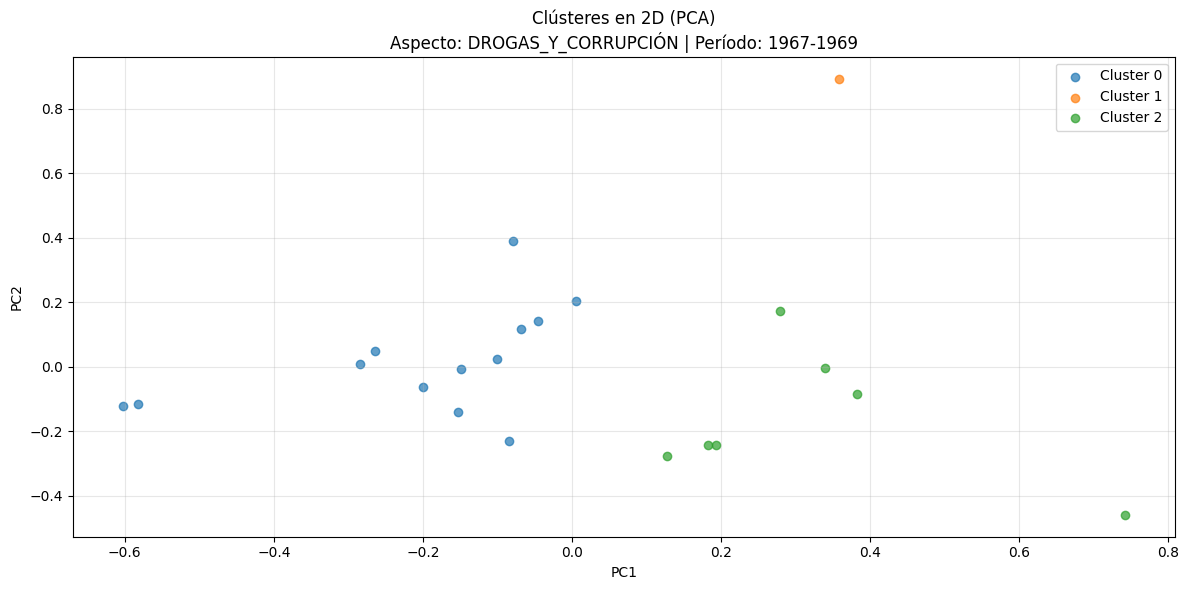


Procesando período: 1970-1972

Países con más de una elección en el período:

Netherlands:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
457,1971,Netherlands,0.615125,0.914379,0.391316,1.688547,0.423078,2.288071,4.970131,1.091855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
458,1972,Netherlands,0.395098,0.337003,0.453249,0.990367,0.631880,1.764612,4.708107,1.200948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.5051
per102: 0.6257
per103: 0.4223
per104: 1.3395
per105: 0.5275
per106: 2.0263
per107: 4.8391
per108: 1.1464
per109: 0.0050
per110: 0.0187
per201: 3.4606
per202: 8.6415
per203: 1.0740
per204: 0.0072
per301: 0.8525
per302: 0.1688
per303: 3.8881
per304: 0.0000
per305: 0.1809
per401: 1.9651
per402: 1.9151
per403: 2.2505
per404: 1.7451
per405: 0.0917
per406: 0.0433
per407: 0.0541
per408: 1.3290
per409: 0.7986
per410: 0.5486
per411: 4.0336
per412: 1.5625
per413: 0.3478
per414: 2.6845
per415: 0.0000
per416: 0.0000
per501: 5.8858
per502: 4.1313
per503: 6.2297
per504: 10.1401
per505: 0.2452
per506: 5.6946
per507: 0.1850
per601: 0.0363
per602: 0.0040
per603: 1.3136
per604: 1.3006
per605: 1.3284
per606: 0.3727
per607: 0.6202
per608: 0.0431
per701: 0.6499
per702: 0.0000
per703: 0.7583
per704: 1.1380
per705: 0.5305
per706: 4.6422
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
6,1970,Finland,1.146349,0.0,0.0,0.020541,0.0,1.832515,3.044272,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1972,Finland,1.628134,0.0,0.0,0.038354,0.0,1.815800,0.321712,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 1.3872
per102: 0.0000
per103: 0.0000
per104: 0.0294
per105: 0.0000
per106: 1.8242
per107: 1.6830
per108: 0.0000
per109: 0.4020
per110: 0.0000
per201: 4.5327
per202: 7.0918
per203: 0.3784
per204: 1.7243
per301: 0.9182
per302: 0.0000
per303: 0.1171
per304: 0.6697
per305: 10.9239
per401: 2.4299
per402: 0.5147
per403: 0.6996
per404: 7.5619
per405: 0.3794
per406: 0.1844
per407: 0.0000
per408: 3.4736
per409: 0.0000
per410: 1.2248
per411: 1.2894
per412: 1.2161
per413: 0.0000
per414: 0.2479
per415: 0.4832
per416: 0.0294
per501: 1.5781
per502: 0.6485
per503: 14.3296
per504: 7.5923
per505: 0.1714
per506: 2.8697
per507: 0.5387
per601: 0.5363
per602: 0.0000
per603: 1.6080
per604: 0.0000
per605: 0.0173
per606: 3.4522
per607: 0.3533
per608: 0.0000
per701: 5.7900
per702: 0.6070
per703: 4.7162
per704: 0.1172
per705: 1.0427
per706: 1.0268
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023:

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
1,1970,Austria,1.035529,0.401685,0.0,2.873584,0.000000,1.514222,7.496861,0.083975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1971,Austria,0.022121,0.393520,0.0,1.430548,0.253727,0.218622,1.254906,1.106998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.5288
per102: 0.3976
per103: 0.0000
per104: 2.1521
per105: 0.1269
per106: 0.8664
per107: 4.3759
per108: 0.5955
per109: 0.0000
per110: 0.0221
per201: 2.2441
per202: 10.0524
per203: 0.8202
per204: 0.0000
per301: 0.7777
per302: 0.0000
per303: 0.1372
per304: 0.2537
per305: 0.2266
per401: 2.2987
per402: 2.0843
per403: 3.5403
per404: 2.7991
per405: 0.0000
per406: 0.0453
per407: 0.0415
per408: 0.5573
per409: 0.0000
per410: 1.9775
per411: 12.7344
per412: 0.0000
per413: 0.3231
per414: 3.3870
per415: 0.0000
per416: 0.0000
per501: 1.9039
per502: 4.2675
per503: 4.3645
per504: 4.8100
per505: 2.8639
per506: 4.5839
per507: 1.1368
per601: 0.0000
per602: 0.0000
per603: 0.3624
per604: 0.0000
per605: 1.3854
per606: 0.7655
per607: 0.3612
per608: 0.0000
per701: 1.0618
per702: 0.0000
per703: 4.3950
per704: 0.3428
per705: 0.5690
per706: 6.1214
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023:

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1972,Australia,1.952266,0.000000,0.789720,3.321291,0.000000,1.132732,2.071846,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1971,Belgium,0.050872,0.021395,1.463169,0.456062,0.086598,0.648233,1.072834,3.245706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1972,Canada,0.350317,0.000000,0.000000,0.208420,0.000000,0.520350,1.103275,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1971,Denmark,0.349736,0.121833,0.000000,0.485306,0.689408,0.073083,0.193713,1.415339,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1972,Germany,4.392585,0.000000,0.000000,1.807972,0.257319,1.614751,1.357895,4.199364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1971,Iceland,0.800514,0.000000,0.000000,1.264869,1.575505,0.464354,1.595626,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1972,Italy,0.043738,0.000000,0.000000,0.753998,0.357584,0.782174,1.526399,3.116130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1972,Japan,3.666674,2.906042,0.000000,2.672253,3.337119,5.297070,3.982121,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1972,New Zealand,0.817774,0.000000,0.000000,2.790758,0.093207,0.697725,2.449057,0.199494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1970,Sri Lanka,0.000000,0.000000,1.200000,0.000000,0.000000,0.150000,2.150000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


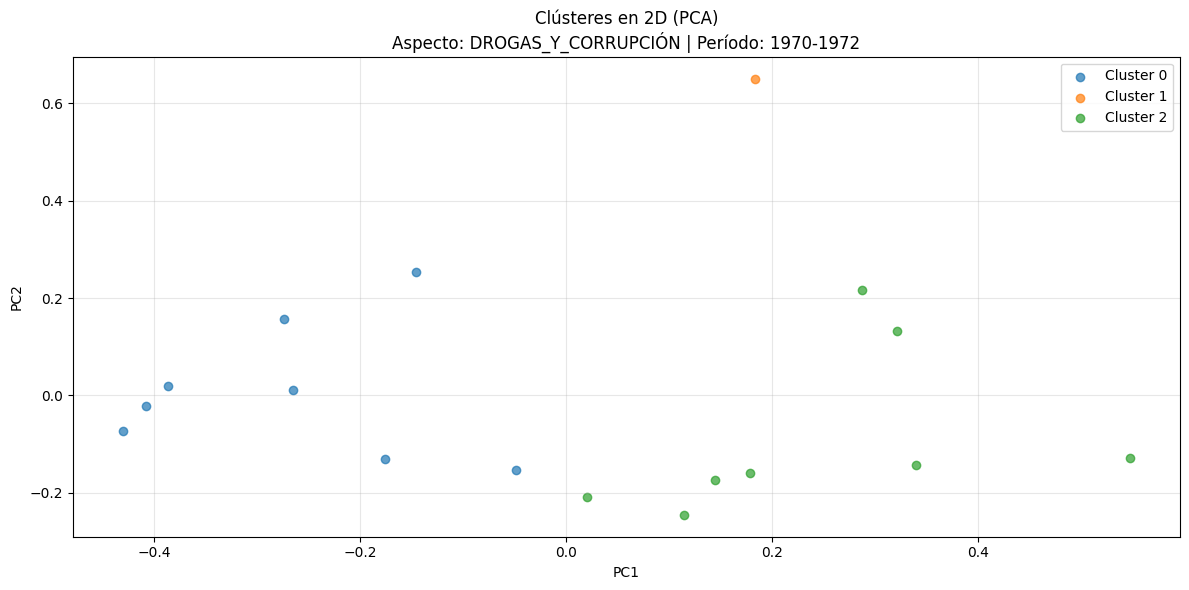


Procesando período: 1973-1975

Países con más de una elección en el período:

Australia:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
30,1974,Australia,1.483420,0.065333,0.000000,1.848683,0.0,0.360895,1.569537,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,1975,Australia,0.014891,0.005415,0.182825,1.189412,0.0,0.000000,0.186886,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.7492
per102: 0.0354
per103: 0.0914
per104: 1.5190
per105: 0.0000
per106: 0.1804
per107: 0.8782
per108: 0.0000
per109: 0.0731
per110: 0.0000
per201: 1.4270
per202: 10.4522
per203: 1.0045
per204: 0.0000
per301: 2.5456
per302: 0.0000
per303: 3.0127
per304: 0.5305
per305: 8.5710
per401: 3.4949
per402: 0.7565
per403: 0.8465
per404: 0.0881
per405: 0.0000
per406: 0.0860
per407: 0.1031
per408: 2.2220
per409: 0.2686
per410: 0.5196
per411: 2.5030
per412: 0.0000
per413: 1.0270
per414: 15.1447
per415: 0.0000
per416: 0.0000
per501: 0.7616
per502: 1.6169
per503: 3.6189
per504: 5.1946
per505: 0.2305
per506: 3.3809
per507: 0.0327
per601: 0.4301
per602: 0.0000
per603: 0.3529
per604: 0.0000
per605: 0.0054
per606: 2.1949
per607: 0.1763
per608: 0.0000
per701: 10.3616
per702: 1.2889
per703: 4.9304
per704: 0.9027
per705: 0.0000
per706: 3.7373
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
3,1973,Denmark,0.098453,0.00591,0.005910,0.569714,0.367899,0.627387,1.737409,1.032658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1975,Denmark,0.241806,0.05464,0.054759,0.376290,0.258181,0.166354,0.376290,0.186928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.1701
per102: 0.0303
per103: 0.0303
per104: 0.4730
per105: 0.3130
per106: 0.3969
per107: 1.0568
per108: 0.6098
per109: 0.1724
per110: 0.9337
per201: 1.6010
per202: 2.3205
per203: 0.2124
per204: 0.1627
per301: 1.4680
per302: 0.1396
per303: 3.6650
per304: 0.0000
per305: 0.2560
per401: 1.5416
per402: 4.2904
per403: 1.0729
per404: 0.1778
per405: 1.2126
per406: 0.0000
per407: 0.0679
per408: 1.3160
per409: 0.4189
per410: 3.6848
per411: 0.8279
per412: 2.2970
per413: 0.6387
per414: 5.7242
per415: 0.0000
per416: 0.0000
per501: 2.3564
per502: 0.3527
per503: 7.5000
per504: 2.6831
per505: 0.5239
per506: 1.1039
per507: 0.8341
per601: 0.8467
per602: 0.0000
per603: 2.7685
per604: 0.0000
per605: 0.6250
per606: 0.6352
per607: 0.0181
per608: 0.0000
per701: 0.7003
per702: 0.0328
per703: 0.1757
per704: 0.3603
per705: 0.3069
per706: 1.3597
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1975,Austria,1.574732,1.486008,0.000000,0.771345,0.000000,1.075695,4.590226,0.994526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1974,Belgium,0.372361,0.000000,0.448929,0.191294,1.140224,0.926934,0.446785,2.065651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1974,Canada,0.046737,0.000000,0.155791,0.137905,0.000000,0.218108,0.557773,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1975,Finland,0.938812,0.000000,0.209402,0.038911,0.000000,1.219032,0.447259,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1973,France,0.613578,0.175581,1.023672,1.330937,0.808088,1.959625,1.545105,2.561426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1974,Greece,4.619195,0.743067,4.716320,1.095750,0.249119,0.604208,0.657189,1.029899,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1974,Iceland,0.000000,0.000000,0.000000,5.795099,0.604524,0.000000,0.263951,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1973,Ireland,0.000000,6.933919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1973,Israel,1.790712,0.514059,0.524943,17.526838,0.336924,19.301659,3.730869,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1974,Luxembourg,2.524597,0.693016,0.065546,0.000000,0.104308,0.319971,0.665198,1.124180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Registros eliminados por tener todas las variables seleccionadas en cero:


,countryname,agno,per603,per604,per605,per104,per304
7,Ireland,1973,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


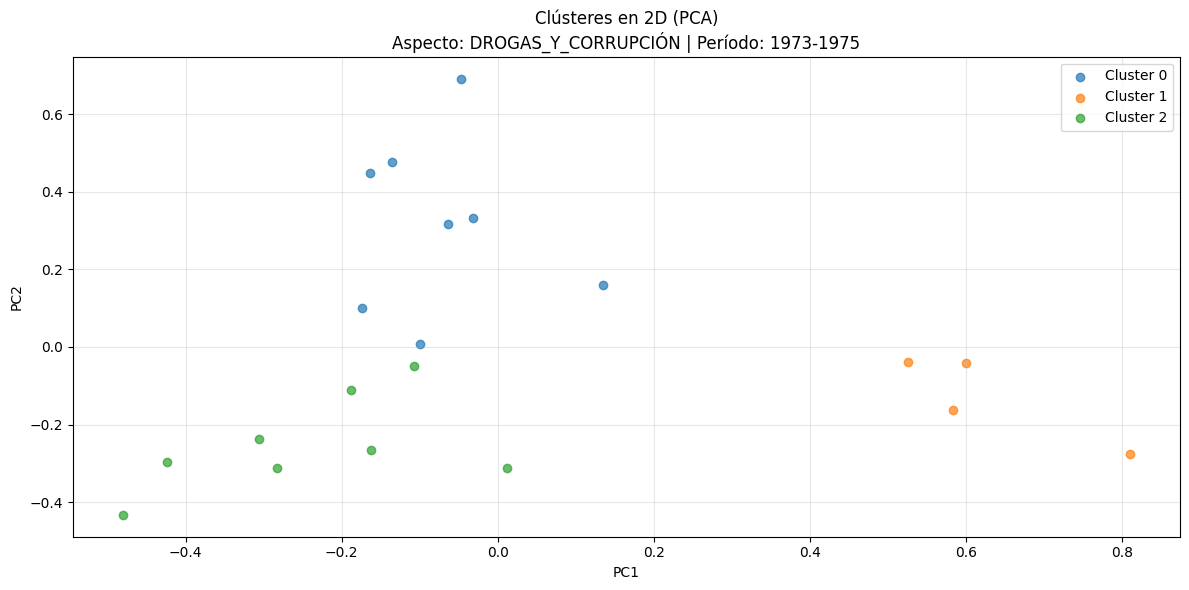


Procesando período: 1976-1978

Países con más de una elección en el período:

Belgium:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
84,1977,Belgium,0.201074,0.0,1.084049,0.093046,1.325118,0.055792,0.677943,5.040086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,1978,Belgium,0.332158,0.0,0.934482,0.577154,0.564640,0.228781,0.801604,2.825655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.2666
per102: 0.0000
per103: 1.0093
per104: 0.3351
per105: 0.9449
per106: 0.1423
per107: 0.7398
per108: 3.9329
per109: 0.6788
per110: 0.3174
per201: 2.9386
per202: 5.0208
per203: 0.4787
per204: 0.3870
per301: 4.8880
per302: 0.0215
per303: 3.1627
per304: 0.3845
per305: 0.8823
per401: 3.1863
per402: 2.4303
per403: 2.0521
per404: 1.6454
per405: 0.0000
per406: 0.0429
per407: 0.0730
per408: 4.8469
per409: 0.3776
per410: 0.6337
per411: 4.6877
per412: 0.8864
per413: 0.6433
per414: 1.8161
per415: 0.0000
per416: 0.0043
per501: 3.2892
per502: 5.5790
per503: 4.1566
per504: 3.8341
per505: 0.6107
per506: 1.5562
per507: 0.0316
per601: 0.3937
per602: 0.2357
per603: 1.0490
per604: 0.2447
per605: 0.2870
per606: 0.9030
per607: 1.4855
per608: 0.4589
per701: 0.9552
per702: 0.0000
per703: 1.4542
per704: 3.4094
per705: 2.1842
per706: 10.8459
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1977,Australia,0.128136,0.000000,0.000000,2.553682,0.000000,0.000000,0.197086,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1977,Denmark,0.115122,0.055057,0.027529,2.307681,0.627273,0.090111,0.077748,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1978,France,1.019204,0.000000,0.846737,1.496261,0.725335,2.320743,0.216787,1.040451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1976,Germany,7.917749,0.274286,0.034035,2.384468,0.773688,1.562101,1.664045,5.090792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1977,Greece,2.622267,3.198469,2.693035,2.675321,0.314634,1.298787,1.218788,1.484450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1978,Iceland,0.000000,0.000000,0.000000,3.365806,0.751089,0.500726,0.500726,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1977,Ireland,0.000000,1.363294,0.000000,1.037176,0.000000,0.109176,1.200470,0.545882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1977,Israel,1.202917,0.000000,0.000000,8.632564,0.031819,6.501675,4.084878,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1976,Italy,0.154209,0.000000,0.000000,0.862346,0.037576,0.460048,0.574614,2.431110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1976,Japan,5.390476,2.217737,0.000000,4.110481,3.214124,2.806382,2.444800,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


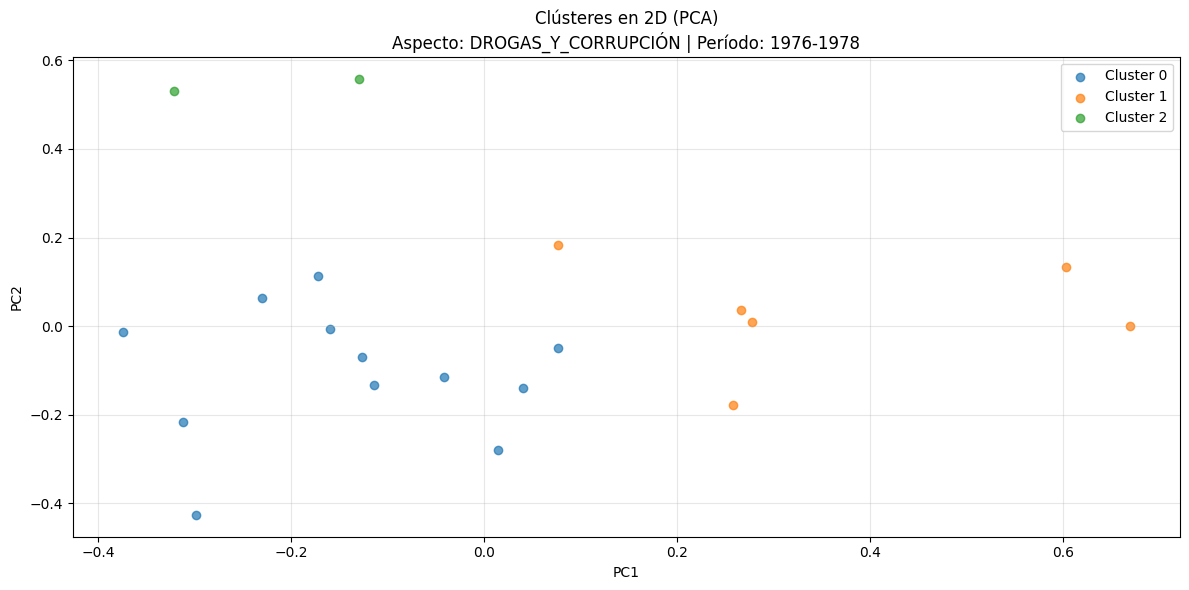


Procesando período: 1979-1981

Países con más de una elección en el período:

Canada:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
129,1979,Canada,0.000000,0.0,0.816860,3.238159,0.0,0.475104,2.238732,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,1980,Canada,0.168042,0.0,0.555738,0.168042,0.0,0.260610,0.581826,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.0840
per102: 0.0000
per103: 0.6863
per104: 1.7031
per105: 0.0000
per106: 0.3679
per107: 1.4103
per108: 0.0000
per109: 0.0000
per110: 0.0000
per201: 1.1246
per202: 1.3890
per203: 0.0000
per204: 0.0000
per301: 1.9530
per302: 1.3637
per303: 3.0762
per304: 0.0382
per305: 0.4517
per401: 5.9932
per402: 6.3309
per403: 1.0594
per404: 1.5006
per405: 0.2073
per406: 1.0681
per407: 0.0886
per408: 11.5406
per409: 2.6489
per410: 1.8872
per411: 11.8633
per412: 1.3565
per413: 2.0355
per414: 2.7794
per415: 0.0000
per416: 0.0000
per501: 1.2252
per502: 0.3418
per503: 2.2945
per504: 7.6721
per505: 0.0382
per506: 0.0000
per507: 0.0000
per601: 0.0681
per602: 0.0000
per603: 0.1338
per604: 0.0000
per605: 0.4913
per606: 0.0667
per607: 4.5910
per608: 2.9667
per701: 0.2738
per702: 0.0000
per703: 1.2205
per704: 1.5610
per705: 1.1010
per706: 7.9263
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023:

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
3,1979,Denmark,0.034277,0.018457,0.0,0.574764,0.805317,0.000000,0.382854,0.055001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1981,Denmark,0.220548,0.182235,0.0,0.159354,1.202395,1.002767,0.655957,0.485965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.1274
per102: 0.1003
per103: 0.0000
per104: 0.3671
per105: 1.0039
per106: 0.5014
per107: 0.5194
per108: 0.2705
per109: 0.0023
per110: 0.2905
per201: 2.3747
per202: 1.8259
per203: 0.0000
per204: 0.0000
per301: 1.0716
per302: 0.0128
per303: 1.0435
per304: 0.0000
per305: 1.1632
per401: 3.5186
per402: 2.0305
per403: 0.8997
per404: 0.5373
per405: 1.0930
per406: 0.1221
per407: 0.0210
per408: 14.3530
per409: 0.0937
per410: 4.2229
per411: 1.5354
per412: 2.2550
per413: 0.9080
per414: 7.1830
per415: 0.0000
per416: 0.0000
per501: 0.8646
per502: 0.4346
per503: 5.7909
per504: 3.0623
per505: 2.0712
per506: 1.0416
per507: 0.0448
per601: 1.7497
per602: 0.0000
per603: 1.2489
per604: 0.1898
per605: 1.2192
per606: 1.8648
per607: 0.0130
per608: 0.0349
per701: 2.3394
per702: 0.5745
per703: 0.8933
per704: 0.2587
per705: 0.5547
per706: 4.1293
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
18,1979,Portugal,0.424245,0.273274,1.156780,1.245270,0.231405,0.767502,1.025971,2.174736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,1980,Portugal,0.728261,0.000000,0.774806,1.492082,0.287679,0.435111,0.913133,1.368808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.5763
per102: 0.1366
per103: 0.9658
per104: 1.3687
per105: 0.2595
per106: 0.6013
per107: 0.9696
per108: 1.7718
per109: 0.6253
per110: 0.0731
per201: 1.8718
per202: 5.0729
per203: 3.6305
per204: 0.9064
per301: 3.3369
per302: 0.0000
per303: 5.0640
per304: 0.2940
per305: 15.6385
per401: 2.1921
per402: 2.0156
per403: 1.1516
per404: 0.6769
per405: 0.2876
per406: 0.0000
per407: 0.2050
per408: 2.8694
per409: 0.0000
per410: 3.1021
per411: 2.7372
per412: 0.4743
per413: 0.2731
per414: 3.2412
per415: 0.6843
per416: 0.0000
per501: 2.2989
per502: 3.1927
per503: 3.8930
per504: 5.7923
per505: 0.2389
per506: 4.3730
per507: 0.0000
per601: 0.3553
per602: 0.0847
per603: 0.6999
per604: 0.0081
per605: 1.6536
per606: 2.0164
per607: 0.1281
per608: 0.0000
per701: 1.7556
per702: 0.1622
per703: 4.8125
per704: 0.1693
per705: 1.2004
per706: 2.1260
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
11,1979,Japan,3.950819,2.355928,0.0,1.597104,3.763388,4.975580,2.233172,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,1980,Japan,1.909968,2.402255,0.0,3.751217,1.472398,4.243034,0.844991,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 2.9304
per102: 2.3791
per103: 0.0000
per104: 2.6742
per105: 2.6179
per106: 4.6093
per107: 1.5391
per108: 0.0000
per109: 0.0000
per110: 0.0000
per201: 0.0596
per202: 1.2970
per203: 0.8189
per204: 0.0000
per301: 0.4645
per302: 0.0000
per303: 7.7819
per304: 12.8388
per305: 0.6029
per401: 0.0535
per402: 0.1665
per403: 8.5877
per404: 1.1534
per405: 0.0000
per406: 0.0000
per407: 0.0000
per408: 2.0556
per409: 0.8783
per410: 0.1442
per411: 6.5488
per412: 0.6445
per413: 0.1426
per414: 6.2501
per415: 0.0000
per416: 0.0000
per501: 1.4497
per502: 0.0000
per503: 12.3467
per504: 9.0748
per505: 0.0000
per506: 7.1772
per507: 0.0000
per601: 0.2114
per602: 0.0000
per603: 0.0767
per604: 0.0000
per605: 0.0000
per606: 0.0000
per607: 0.0000
per608: 0.0000
per701: 0.4822
per702: 0.0000
per703: 0.0000
per704: 0.2867
per705: 0.0000
per706: 0.0767
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023:

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1980,Australia,0.729623,0.000000,0.197495,1.902704,0.197495,0.197495,1.098019,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1979,Austria,0.773191,0.036747,0.000000,0.877308,0.000000,0.294477,2.433915,0.036747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1981,Belgium,0.281304,0.118599,1.484366,0.926452,0.482519,0.602547,1.280394,1.861300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1979,Finland,1.331360,0.000000,0.000000,0.000000,0.163952,0.660327,1.500163,0.146498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1981,France,1.648116,0.202412,0.650283,1.020997,1.196962,1.601787,1.422539,0.994550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1980,Germany,4.001119,2.028090,0.033601,2.555375,2.439467,2.137977,3.380060,3.415926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1981,Greece,0.355665,0.547186,3.756721,2.110013,0.254336,1.210329,1.785593,1.933213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1979,Iceland,0.000000,0.000000,0.000000,0.179009,1.269553,0.358018,0.465309,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1981,Ireland,0.066920,1.765041,0.025747,0.687934,0.020587,0.497517,1.407389,0.396970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1981,Israel,1.704367,0.923058,0.000000,4.746186,0.306284,5.092443,1.301929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


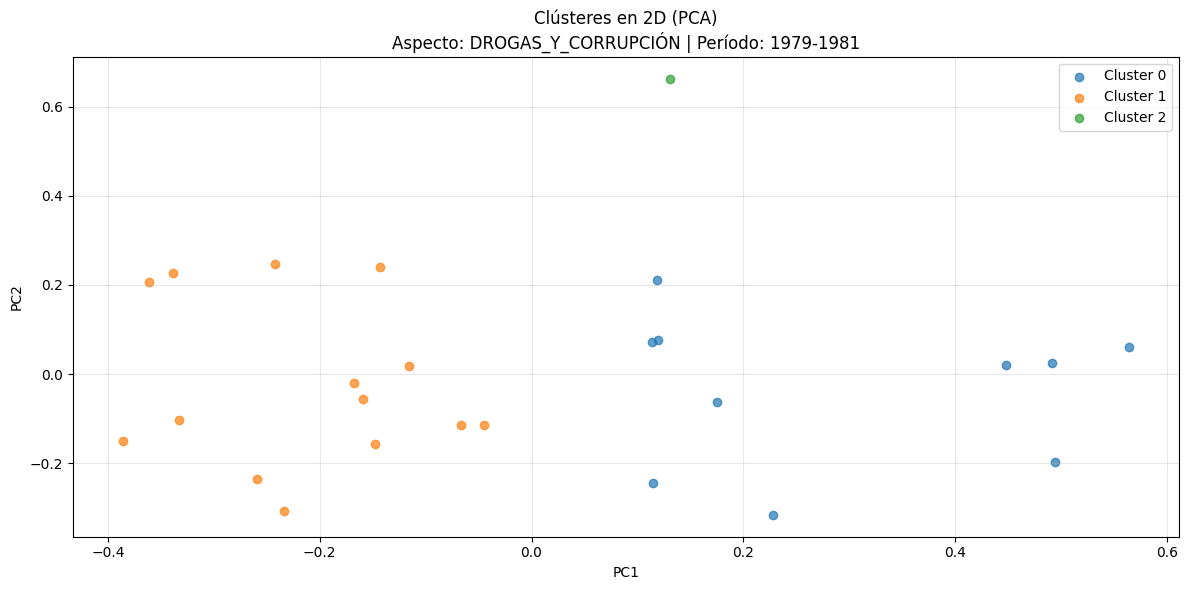


Procesando período: 1982-1984

Países con más de una elección en el período:

Australia:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
34,1983,Australia,0.000000,0.000000,0.0,3.264448,0.0,0.406168,0.812336,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,1984,Australia,1.248174,0.280323,0.0,4.392641,0.0,2.959357,0.881933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.6241
per102: 0.1402
per103: 0.0000
per104: 3.8285
per105: 0.0000
per106: 1.6828
per107: 0.8471
per108: 0.0000
per109: 0.0000
per110: 0.0000
per201: 0.8107
per202: 0.7265
per203: 1.7381
per204: 0.0000
per301: 0.1361
per302: 0.0000
per303: 2.5377
per304: 0.0798
per305: 1.0279
per401: 3.6150
per402: 5.8324
per403: 1.1164
per404: 1.7552
per405: 0.0557
per406: 0.3872
per407: 0.6056
per408: 3.6310
per409: 0.0000
per410: 6.1008
per411: 4.5932
per412: 0.2393
per413: 0.4254
per414: 3.2948
per415: 0.0000
per416: 0.0000
per501: 2.0388
per502: 2.9376
per503: 2.7662
per504: 4.0878
per505: 0.3901
per506: 4.3959
per507: 0.0000
per601: 4.1855
per602: 0.0000
per603: 2.2413
per604: 0.0000
per605: 1.3137
per606: 5.0290
per607: 0.5374
per608: 0.0372
per701: 0.3061
per702: 2.4002
per703: 3.5474
per704: 0.2402
per705: 0.5332
per706: 8.7510
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1983,Austria,0.036383,0.000000,0.099418,0.480169,1.065904,1.500602,1.350812,0.062371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1984,Canada,1.146910,0.213517,0.000000,2.374409,1.067586,1.980263,2.407298,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1984,Denmark,0.074839,0.986874,0.009261,1.843065,2.812095,1.391364,1.267753,0.693594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1983,Finland,0.662496,0.000000,0.100256,0.028239,0.228891,2.447006,1.677304,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1983,Germany,4.320292,1.074031,0.000000,2.718324,3.433384,3.193914,2.905198,2.401412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1983,Iceland,0.030535,0.000000,0.000000,0.591843,2.651217,0.783849,1.374140,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1982,Ireland,1.806442,0.007851,0.039312,0.000000,2.242132,2.711850,1.811644,1.005583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1984,Israel,1.197655,1.197655,0.167605,12.830260,1.430629,6.158105,1.802564,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1983,Italy,0.706046,0.032281,0.000000,0.466780,0.227512,1.879600,1.507824,1.811591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1983,Japan,0.287766,0.161097,0.161097,2.313051,6.715085,3.823815,4.913360,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


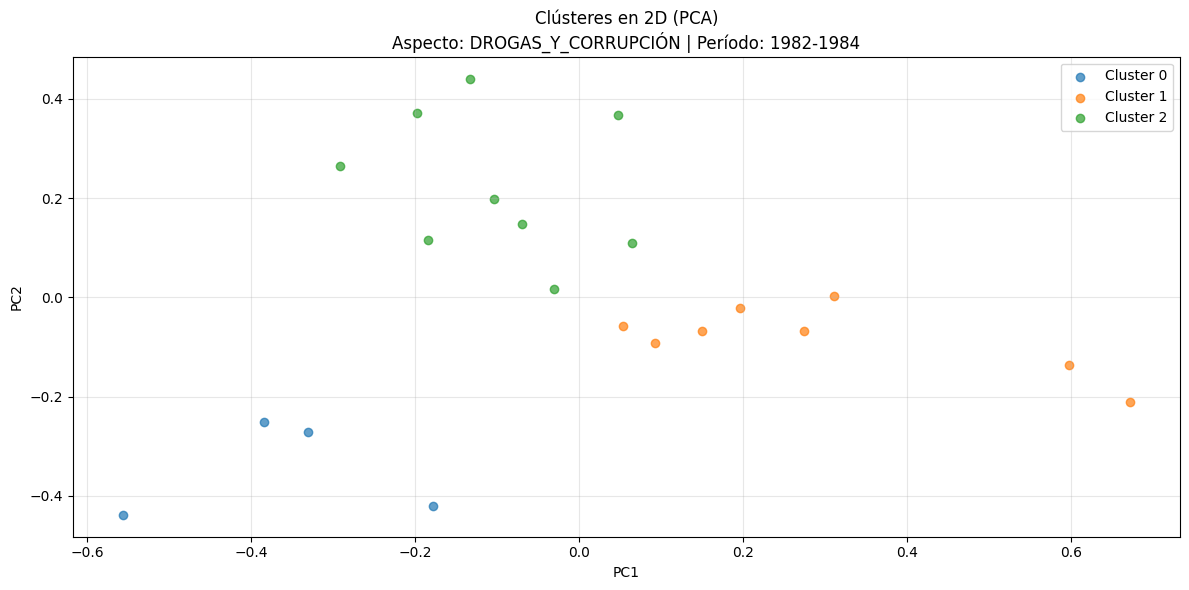


Procesando período: 1985-1987

Países con más de una elección en el período:

Belgium:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
87,1985,Belgium,0.280882,0.007637,1.303739,1.354955,1.090661,1.308769,1.452319,2.689762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,1987,Belgium,0.300835,0.043828,1.938822,0.842439,0.623572,1.568072,0.872666,3.701539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.2909
per102: 0.0257
per103: 1.6213
per104: 1.0987
per105: 0.8571
per106: 1.4384
per107: 1.1625
per108: 3.1957
per109: 0.0000
per110: 0.0000
per201: 2.1496
per202: 2.9752
per203: 0.2074
per204: 0.0199
per301: 4.1736
per302: 0.7828
per303: 4.3913
per304: 0.5697
per305: 0.9902
per401: 2.4462
per402: 4.4904
per403: 0.8735
per404: 0.4356
per405: 0.0000
per406: 0.1868
per407: 0.0052
per408: 4.5933
per409: 0.0444
per410: 2.3707
per411: 4.4043
per412: 0.2884
per413: 0.3758
per414: 1.7147
per415: 0.0000
per416: 0.1497
per501: 5.0641
per502: 5.3224
per503: 2.2456
per504: 4.7067
per505: 0.7248
per506: 4.9155
per507: 0.0000
per601: 0.4961
per602: 0.0043
per603: 2.4894
per604: 0.2411
per605: 2.1802
per606: 1.4852
per607: 1.1318
per608: 0.4029
per701: 0.7196
per702: 0.1386
per703: 1.6088
per704: 1.8683
per705: 1.5339
per706: 7.4947
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
15,1985,Portugal,0.431005,0.0,0.579541,0.599076,0.507705,0.143401,0.012631,3.116781,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1987,Portugal,0.074395,0.0,0.079846,0.074395,0.631125,0.292457,0.063508,2.665319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.2527
per102: 0.0000
per103: 0.3297
per104: 0.3367
per105: 0.5694
per106: 0.2179
per107: 0.0381
per108: 2.8910
per109: 0.2374
per110: 0.2380
per201: 1.9261
per202: 2.5408
per203: 1.5468
per204: 0.3223
per301: 2.5320
per302: 0.0000
per303: 5.1852
per304: 2.6782
per305: 20.7352
per401: 2.1392
per402: 2.2473
per403: 0.4614
per404: 0.0358
per405: 1.5884
per406: 0.1668
per407: 0.2157
per408: 6.0677
per409: 0.0000
per410: 4.4700
per411: 3.5645
per412: 0.2704
per413: 0.0640
per414: 4.3137
per415: 0.3136
per416: 0.0000
per501: 0.5239
per502: 0.8678
per503: 4.2314
per504: 7.2422
per505: 0.0000
per506: 5.9271
per507: 0.0000
per601: 0.0000
per602: 0.0000
per603: 0.2637
per604: 0.0000
per605: 0.5699
per606: 2.3114
per607: 0.0000
per608: 0.0000
per701: 2.5530
per702: 0.2149
per703: 1.3411
per704: 0.4952
per705: 0.5311
per706: 1.3952
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1987,Australia,0.350532,0.000000,0.000000,2.250650,0.000000,4.098095,0.050283,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1986,Austria,0.130699,0.000000,0.000000,0.733538,0.394910,0.559568,2.227649,0.226179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1987,Denmark,0.268734,0.000000,0.000000,0.137069,1.422696,0.418018,1.159439,0.122553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1987,Finland,0.938942,0.044013,0.644315,0.612787,0.532575,1.485064,1.906866,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1986,France,1.603790,0.112036,0.000000,1.821847,0.081235,1.041198,2.239462,2.907265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1987,Germany,3.264963,0.016986,0.016986,3.085876,3.684290,1.500479,2.281483,7.113733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1985,Greece,0.250505,0.560560,1.980281,1.601715,0.257100,1.902307,1.147315,0.322466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1987,Iceland,0.286632,0.000000,0.000000,1.357188,2.549641,0.484282,2.445676,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1987,Ireland,2.637462,0.005680,0.209882,0.813374,0.269851,0.301237,0.879771,0.545810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1987,Italy,0.251533,0.488916,0.000000,0.595969,0.697211,0.595091,2.623721,2.753274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


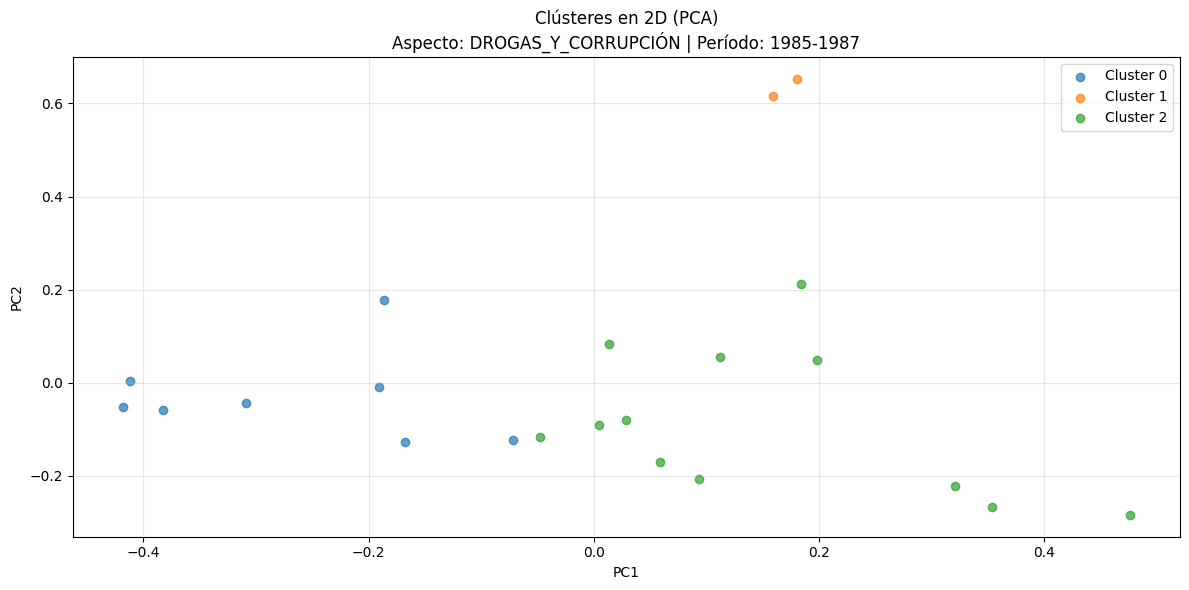


Procesando período: 1988-1990

Países con más de una elección en el período:

Denmark:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
190,1988,Denmark,0.399851,0.282978,0.0,9.967767,2.087737,0.116873,1.623160,2.344217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191,1990,Denmark,2.525931,0.332780,0.0,2.882637,0.268335,0.487194,2.680192,5.496289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 1.4629
per102: 0.3079
per103: 0.0000
per104: 6.4252
per105: 1.1780
per106: 0.3020
per107: 2.1517
per108: 3.9203
per109: 0.8976
per110: 0.8554
per201: 0.8614
per202: 2.3793
per203: 0.0383
per204: 0.0159
per301: 1.3570
per302: 0.1967
per303: 1.7576
per304: 0.1254
per305: 0.5727
per401: 1.4683
per402: 4.3018
per403: 0.6458
per404: 0.3127
per405: 0.9686
per406: 0.0000
per407: 0.0658
per408: 3.3659
per409: 0.0195
per410: 0.9071
per411: 2.1874
per412: 1.0050
per413: 0.0268
per414: 0.5495
per415: 0.0195
per416: 0.1979
per501: 4.9930
per502: 0.4180
per503: 3.3209
per504: 5.4938
per505: 1.0866
per506: 3.4957
per507: 0.0435
per601: 0.1557
per602: 0.0537
per603: 1.6161
per604: 0.0000
per605: 2.0639
per606: 2.1533
per607: 0.1162
per608: 0.1062
per701: 7.6167
per702: 0.2547
per703: 0.6099
per704: 0.2217
per705: 0.0000
per706: 4.6578
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
11,1989,Greece,0.302491,0.270196,1.012922,0.799358,0.101481,0.540832,0.601850,1.552357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,1990,Greece,0.346302,0.587567,0.473731,2.855823,0.610895,0.821283,0.734175,1.275834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.3244
per102: 0.4289
per103: 0.7433
per104: 1.8276
per105: 0.3562
per106: 0.6811
per107: 0.6680
per108: 1.4141
per109: 0.2974
per110: 0.0482
per201: 3.0970
per202: 6.2049
per203: 0.0318
per204: 0.0076
per301: 1.5810
per302: 0.0000
per303: 1.2538
per304: 5.7251
per305: 8.3048
per401: 0.3825
per402: 0.7123
per403: 1.6227
per404: 0.1220
per405: 0.0045
per406: 0.1059
per407: 0.0258
per408: 4.2146
per409: 0.0000
per410: 2.5805
per411: 2.9431
per412: 0.0824
per413: 0.2728
per414: 2.7501
per415: 0.0045
per416: 0.2253
per501: 2.1299
per502: 2.1401
per503: 2.6962
per504: 7.6133
per505: 0.0373
per506: 3.0461
per507: 0.0000
per601: 4.4573
per602: 0.0076
per603: 0.2379
per604: 0.0000
per605: 1.6624
per606: 6.4170
per607: 0.0270
per608: 0.0000
per701: 3.5183
per702: 0.0091
per703: 1.5541
per704: 0.2075
per705: 0.3480
per706: 1.1769
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1989,Argentina,0.000000,0.000000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
1,1990,Australia,0.616425,0.111083,0.047960,1.627108,0.263780,0.326903,0.880205,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
2,1990,Austria,0.366392,0.000000,0.004970,1.810575,0.177825,0.534368,4.839594,0.979763,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
3,1990,Bosnia-Herzegovina,0.000000,0.000000,0.056480,0.016137,0.016137,0.260946,0.101098,0.602313,...,0.008069,0.0,0.0,0.785474,0.0,0.0,0.604845,0.000000,0.0,0.0
4,1990,Bulgaria,0.414039,0.844949,0.278255,1.646675,0.229692,0.692229,1.081855,1.184445,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.183636,0.000000,0.0,0.0
5,1988,Canada,2.263855,1.404386,0.000000,1.263677,1.632017,3.230925,2.590114,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
6,1989,Chile,0.367161,0.049098,0.204681,2.241851,0.898452,0.567973,4.764237,0.913344,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
7,1990,Costa Rica,0.131391,0.000000,0.117392,0.000000,0.195999,0.854957,1.742650,0.443044,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
8,1988,France,1.131475,0.014897,0.000000,1.520198,0.000000,2.089718,0.969840,4.081707,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
9,1990,Georgia,0.379175,0.585696,4.642187,1.160194,0.010474,0.164387,5.011962,0.024338,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


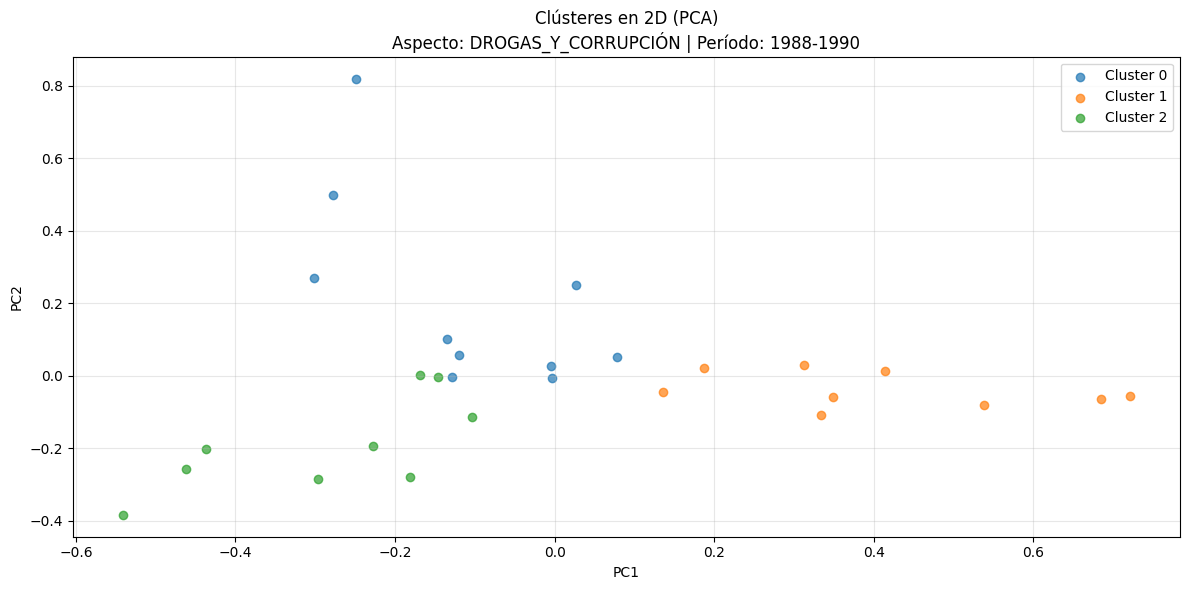


Procesando período: 1991-1993

No hay países con más de una elección en el período.

Dataframe ajustado (un registro por país en el período):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
38,1993,Australia,0.000000,0.000000,0.000000,0.069269,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
89,1991,Belgium,0.369100,0.000000,0.144477,0.763819,0.408593,0.204378,2.010098,2.251799,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
133,1993,Canada,0.000000,0.000000,0.384406,0.026519,0.132524,0.403999,2.298704,0.255153,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
143,1993,Chile,0.289693,0.037331,0.000000,1.127951,0.206192,0.209040,3.254579,0.721319,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
222,1991,Finland,0.000000,0.000000,0.000000,0.362199,0.000000,0.455842,4.196779,2.634577,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
242,1993,France,1.133056,0.021334,0.518797,0.816328,0.276620,1.355013,1.526989,0.918384,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
282,1993,Greece,0.087236,0.059468,0.516118,0.100221,0.054706,0.537540,1.896602,2.388489,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
308,1991,Iceland,0.032178,0.000000,0.000000,0.902408,1.106227,0.268567,5.309849,2.645202,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
330,1992,Ireland,0.000000,0.000000,0.000000,0.000000,0.272448,2.036870,1.617871,3.397418,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
347,1992,Israel,0.000000,0.148720,0.000000,3.753750,0.416691,9.714408,0.360735,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


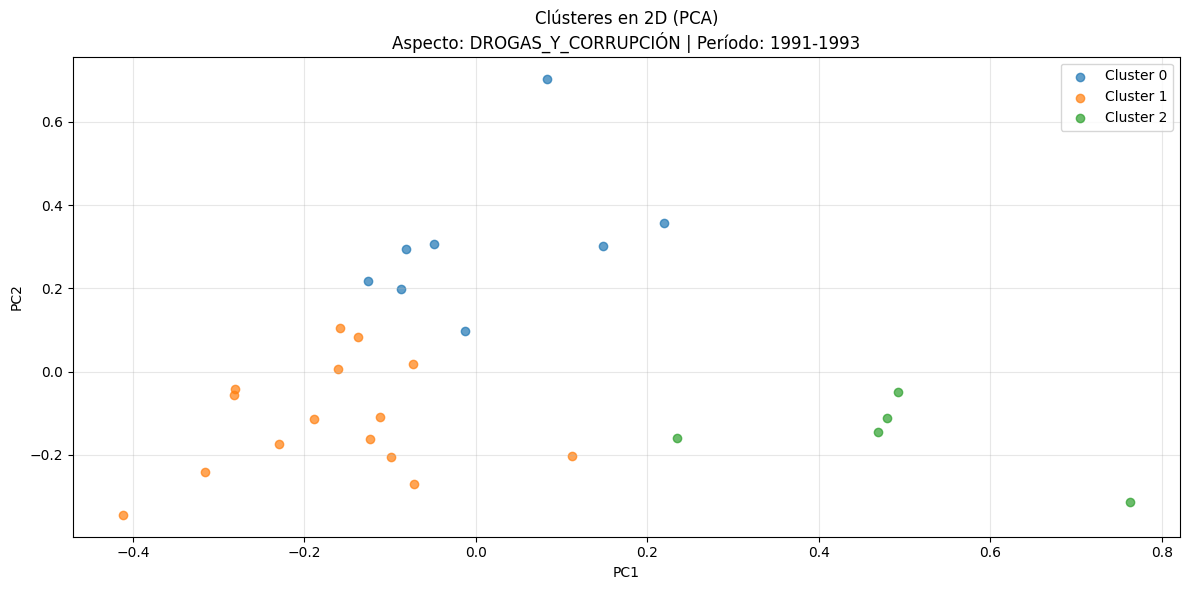


Procesando período: 1994-1996

Países con más de una elección en el período:

Austria:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
62,1994,Austria,0.0,0.0,0.0,1.296950,0.000000,0.435132,3.217248,1.014332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,1995,Austria,0.0,0.0,0.0,0.297979,0.041768,0.787403,2.040493,2.010138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.0000
per102: 0.0000
per103: 0.0000
per104: 0.7975
per105: 0.0209
per106: 0.6113
per107: 2.6289
per108: 1.5122
per109: 0.3671
per110: 0.3636
per201: 4.9681
per202: 2.2607
per203: 1.1890
per204: 0.0000
per301: 0.6372
per302: 0.0256
per303: 8.0418
per304: 4.1051
per305: 10.3292
per401: 6.2473
per402: 3.5749
per403: 0.8556
per404: 0.0640
per405: 0.0421
per406: 0.0549
per407: 0.2746
per408: 3.8976
per409: 0.0823
per410: 2.8806
per411: 4.3500
per412: 0.0144
per413: 0.0586
per414: 3.4086
per415: 0.0000
per416: 0.0250
per501: 5.1389
per502: 1.0048
per503: 6.9750
per504: 3.5271
per505: 1.2768
per506: 3.1195
per507: 0.0000
per601: 1.6126
per602: 0.1256
per603: 1.7638
per604: 0.2364
per605: 3.3267
per606: 1.9865
per607: 0.2342
per608: 0.0723
per701: 1.0026
per702: 0.0000
per703: 0.9077
per704: 0.0707
per705: 1.5341
per706: 1.1712
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1995,Argentina,0.061642,0.020140,0.143247,0.882433,0.083005,1.107286,1.996025,1.669947,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1995,Armenia,1.464277,0.000000,0.080197,2.359801,0.179155,0.253621,2.923357,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.725815
2,1996,Australia,0.028504,0.000000,0.084084,3.244711,0.085511,0.057007,1.521585,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,1995,Azerbaijan,1.261416,0.259177,0.000000,0.518354,0.000000,6.043237,9.565065,0.420510,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,1995,Belarus,0.000000,0.000000,0.116875,0.790000,1.122875,0.861875,2.684625,0.000000,...,0.116875,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
5,1995,Belgium,0.366176,0.000000,0.000000,0.644877,0.276943,0.188200,1.953790,1.890846,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,1994,Brazil,0.118031,0.000000,0.913866,0.419180,0.099375,0.047639,1.244761,0.993176,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7,1994,Costa Rica,0.000000,0.000000,0.000000,0.000000,0.278026,0.092675,0.571743,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
8,1996,Czech Republic,0.271700,0.256019,0.227222,2.680357,0.483592,0.235354,1.120014,2.129594,...,0.525803,0.0,0.0,0.196995,0.0,0.0,0.000000,0.000000,0.000000,0.000000
9,1994,Denmark,0.190336,0.030366,0.000000,0.204077,0.194427,0.071267,2.218958,0.996847,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


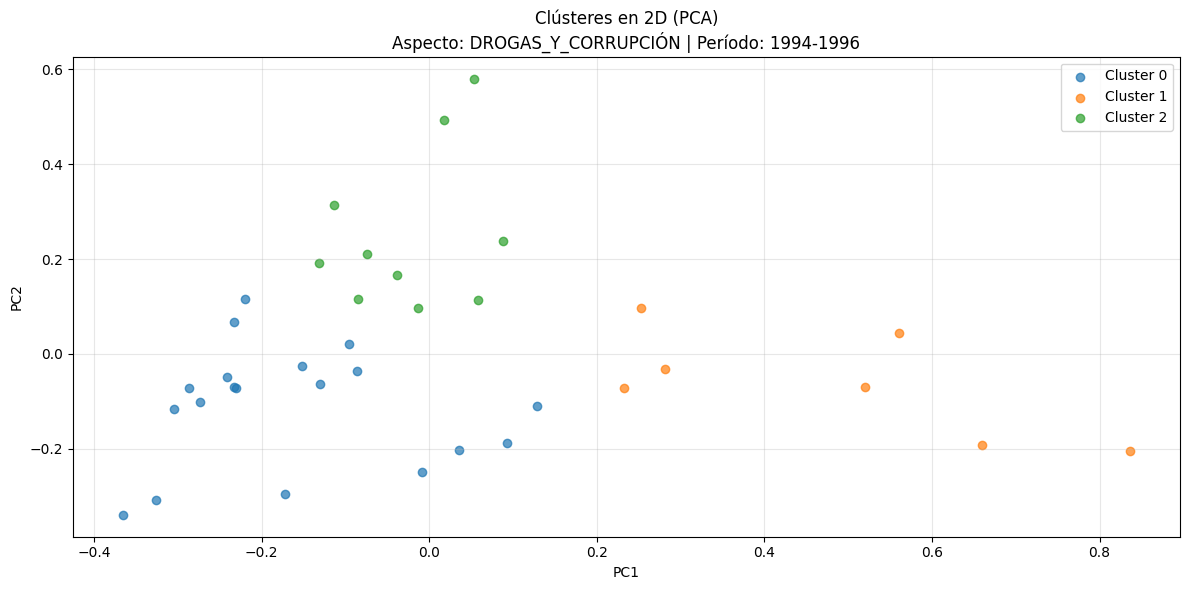


Procesando período: 1997-2000

Países con más de una elección en el período:

Mexico:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
432,1997,Mexico,0.132309,0.438202,0.043970,0.040209,0.163891,0.218070,2.511131,0.052482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433,2000,Mexico,0.318682,0.792830,0.054239,0.334087,0.112517,0.283684,4.479868,0.317412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.2255
per102: 0.6155
per103: 0.0491
per104: 0.1871
per105: 0.1382
per106: 0.2509
per107: 3.4955
per108: 0.1849
per109: 1.4350
per110: 0.0000
per201: 2.8619
per202: 6.4394
per203: 0.7911
per204: 0.1930
per301: 4.0061
per302: 0.0896
per303: 3.9635
per304: 3.5293
per305: 2.4075
per401: 0.9541
per402: 2.1055
per403: 1.7745
per404: 0.3441
per405: 0.0152
per406: 0.3697
per407: 0.5198
per408: 1.0660
per409: 0.0330
per410: 3.5624
per411: 4.6145
per412: 0.0957
per413: 0.4320
per414: 1.6735
per415: 0.0000
per416: 0.0017
per501: 5.6165
per502: 2.1476
per503: 7.1150
per504: 6.7186
per505: 0.0034
per506: 3.7621
per507: 0.0091
per601: 2.3897
per602: 0.0000
per603: 1.1980
per604: 0.2533
per605: 4.7174
per606: 0.9787
per607: 1.2458
per608: 0.0244
per701: 2.5985
per702: 0.2979
per703: 3.7453
per704: 0.3189
per705: 0.8059
per706: 4.5160
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
7,1998,Bosnia-Herzegovina,0.087763,0.0,0.0,0.101130,0.000000,1.070588,0.646156,0.072194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.087763,0.0,1.646551,10.871459
8,2000,Bosnia-Herzegovina,1.130714,0.0,0.0,0.479958,0.121394,0.104105,0.900014,1.148963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.384776,0.0,1.682005,4.609237



Valores promediados:
per101: 0.6092
per102: 0.0000
per103: 0.0000
per104: 0.2905
per105: 0.0607
per106: 0.5873
per107: 0.7731
per108: 0.6106
per109: 0.4425
per110: 0.0000
per201: 5.6629
per202: 5.0763
per203: 3.0959
per204: 1.1205
per301: 1.1635
per302: 0.0000
per303: 0.5912
per304: 0.6349
per305: 0.7063
per401: 3.8367
per402: 0.9569
per403: 0.0000
per404: 0.0000
per405: 0.0663
per406: 0.0191
per407: 0.0935
per408: 5.1656
per409: 0.0000
per410: 1.7780
per411: 5.9793
per412: 0.0000
per413: 0.0000
per414: 1.7480
per415: 0.0000
per416: 0.0000
per501: 1.1655
per502: 2.4914
per503: 1.5734
per504: 7.1331
per505: 0.2328
per506: 4.1683
per507: 0.0242
per601: 5.3459
per602: 1.3840
per603: 0.6634
per604: 0.2064
per605: 0.5799
per606: 1.7550
per607: 7.8735
per608: 0.0699
per701: 0.4725
per702: 0.0000
per703: 2.4965
per704: 1.2618
per705: 0.0968
per706: 2.1092
per1011: 0.0232
per1012: 0.0946
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0944
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
8,1997,Canada,0.000000,0.000000,0.000000,1.104925,0.198206,1.932101,2.082641,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2000,Canada,0.599874,0.306211,0.103557,1.398580,0.082349,0.278703,3.322931,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.2999
per102: 0.1531
per103: 0.0518
per104: 1.2518
per105: 0.1403
per106: 1.1054
per107: 2.7028
per108: 0.0000
per109: 0.0000
per110: 0.0000
per201: 1.6541
per202: 3.3683
per203: 1.6086
per204: 0.6513
per301: 4.3963
per302: 0.2064
per303: 4.5056
per304: 1.0385
per305: 0.5570
per401: 1.9638
per402: 5.2209
per403: 1.6721
per404: 0.8947
per405: 0.0688
per406: 0.0412
per407: 1.3032
per408: 2.0789
per409: 0.7807
per410: 1.6059
per411: 6.0912
per412: 0.0686
per413: 0.2037
per414: 1.6810
per415: 0.0000
per416: 0.0000
per501: 3.9608
per502: 1.3355
per503: 2.8068
per504: 10.2271
per505: 1.2229
per506: 4.4284
per507: 0.0137
per601: 0.4796
per602: 1.1836
per603: 1.8970
per604: 0.0688
per605: 6.5957
per606: 1.7730
per607: 1.8118
per608: 0.0760
per701: 1.5294
per702: 0.0137
per703: 1.6377
per704: 0.6351
per705: 1.1384
per706: 4.0466
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1997,Albania,1.770988,0.000000,0.031388,3.046506,0.015910,0.032313,3.406129,1.114989,...,2.021481,0.0,0.000000,0.000000,0.000000,0.000000,0.637892,0.363756,0.000000,0.000000
1,1999,Argentina,0.192543,0.000000,0.582363,0.524400,0.017829,0.613450,3.482869,2.262154,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1999,Armenia,3.543735,0.000000,0.232025,2.257703,0.000000,1.523616,0.779154,0.057937,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.418237,0.000000,0.000000,0.000000
3,1998,Australia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1999,Austria,0.034200,0.034200,0.000000,1.726270,0.257172,0.572054,3.300893,3.558949,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2000,Azerbaijan,0.073904,0.607544,2.322436,2.648329,0.000000,3.717489,5.581997,0.885290,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1999,Belgium,0.088628,0.000000,0.041465,0.600637,0.302983,0.308011,3.196584,6.746822,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1998,Brazil,0.053763,0.000000,0.340594,0.214496,0.013302,0.210757,0.903161,0.558828,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1999,Chile,0.056430,0.126620,0.000000,2.584547,0.393984,0.112347,1.348291,0.351827,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,1998,Costa Rica,0.000000,0.000000,0.000000,0.000000,0.263693,0.171580,1.147021,0.211310,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


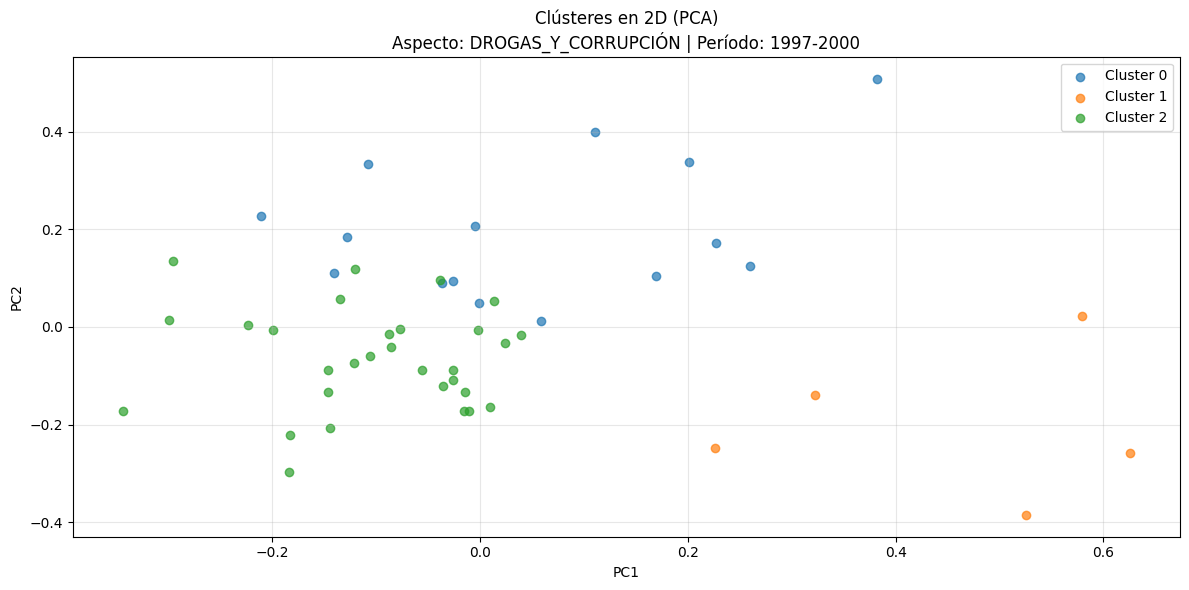


Procesando período: 2001-2003

Países con más de una elección en el período:

Netherlands:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
466,2002,Netherlands,0.257122,0.00231,0.029772,0.712931,0.248638,0.511183,2.421494,3.015283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,2003,Netherlands,0.171076,0.00000,0.021415,0.490239,0.114182,0.376042,2.691287,3.011981,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.2141
per102: 0.0012
per103: 0.0256
per104: 0.6016
per105: 0.1814
per106: 0.4436
per107: 2.5564
per108: 3.0136
per109: 0.0736
per110: 0.1038
per201: 3.1813
per202: 2.6210
per203: 0.1641
per204: 0.0000
per301: 1.6293
per302: 0.0195
per303: 6.4482
per304: 0.1588
per305: 4.3908
per401: 1.6829
per402: 2.9197
per403: 2.1480
per404: 0.0116
per405: 0.0102
per406: 0.0274
per407: 0.5137
per408: 2.3471
per409: 0.0678
per410: 0.4571
per411: 7.0439
per412: 0.0008
per413: 0.0106
per414: 1.6215
per415: 0.0000
per416: 0.5100
per501: 4.2960
per502: 2.2499
per503: 2.6665
per504: 7.3207
per505: 1.0397
per506: 6.7618
per507: 0.0000
per601: 0.7347
per602: 0.0459
per603: 1.5492
per604: 0.1260
per605: 8.2915
per606: 2.5771
per607: 0.2267
per608: 0.8037
per701: 2.2215
per702: 0.0453
per703: 1.4733
per704: 0.4911
per705: 2.1375
per706: 3.1426
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,2001,Albania,2.392570,0.000000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.989546,0.000000,0.000000,0.000000,0.000000,0.000000,0.897238,0.508457,0.000000,0.000000
1,2003,Argentina,0.000000,0.000000,0.022605,0.113333,0.135937,0.233844,2.621821,1.451604,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2003,Armenia,0.509471,1.484511,2.845431,0.767558,0.000000,1.788170,1.417058,0.211141,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.982308,0.000000,0.000000,0.000000
3,2001,Australia,0.000000,0.000000,0.037945,1.665669,0.100453,0.000000,0.325499,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2002,Austria,0.000000,0.000000,0.010478,1.243654,0.166484,0.276933,5.358649,3.777595,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2003,Belgium,0.061143,0.000000,0.002689,0.103174,0.177767,0.638239,3.045314,2.432678,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2002,Bosnia-Herzegovina,0.567753,0.000000,0.015221,1.451305,0.049194,0.211742,1.760145,0.906865,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121521,0.000000,0.837193,1.885129
7,2002,Brazil,0.036415,0.000000,2.255361,1.523614,0.161100,0.440886,1.649189,0.814393,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,2001,Bulgaria,0.245642,0.000000,0.000000,2.297820,0.082694,0.171508,3.193346,3.042853,...,0.000000,0.000000,0.019778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,2002,Colombia,0.074519,0.000000,0.000000,0.316675,0.147880,2.251476,1.083234,0.317802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


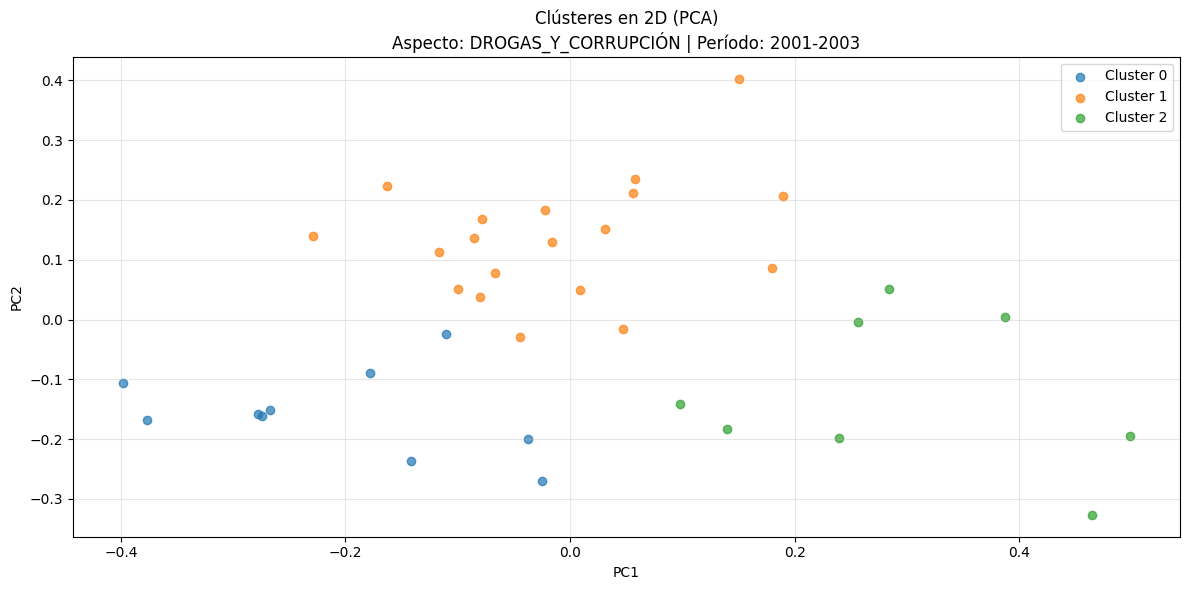


Procesando período: 2004-2006

Países con más de una elección en el período:

Canada:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
136,2004,Canada,1.521181,0.389302,0.030572,2.889574,0.357441,0.196332,4.737747,0.012202,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,2006,Canada,0.321493,0.321230,0.052757,2.636727,0.130456,0.243999,3.488900,0.062421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.9213
per102: 0.3553
per103: 0.0417
per104: 2.7632
per105: 0.2439
per106: 0.2202
per107: 4.1133
per108: 0.0373
per109: 0.3542
per110: 0.0000
per201: 0.7704
per202: 3.4171
per203: 0.3255
per204: 0.2132
per301: 6.8524
per302: 1.1914
per303: 1.5586
per304: 5.1824
per305: 5.0400
per401: 0.3880
per402: 1.4589
per403: 1.3113
per404: 1.0735
per405: 0.1785
per406: 0.9096
per407: 2.3124
per408: 0.7808
per409: 0.1169
per410: 3.4215
per411: 4.5473
per412: 1.6603
per413: 0.1605
per414: 2.7797
per415: 0.0000
per416: 1.0111
per501: 4.5322
per502: 0.6493
per503: 3.6331
per504: 13.4195
per505: 0.0384
per506: 3.9045
per507: 0.0137
per601: 4.0817
per602: 0.4800
per603: 0.4957
per604: 0.3149
per605: 6.6603
per606: 0.3440
per607: 0.9071
per608: 0.0829
per701: 0.6242
per702: 0.0000
per703: 1.6742
per704: 0.0231
per705: 1.2485
per706: 1.1285
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,2004,Australia,0.000000,0.000000,0.193763,2.817487,0.893560,0.083266,1.531278,0.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2006,Austria,0.000000,0.000000,0.000000,1.200320,0.285779,0.282765,4.762931,4.309310,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2006,Bosnia-Herzegovina,1.082046,0.000000,0.000000,0.759583,0.730977,0.280385,1.852017,3.386497,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2006,Brazil,0.000000,0.000000,2.024900,1.033002,0.108022,0.287941,1.468225,0.542497,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2005,Chile,0.501296,0.000000,0.108972,1.237788,0.586723,0.361019,2.251643,0.646983,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2006,Colombia,0.064387,0.007012,0.000000,0.747149,0.718367,0.933315,1.437244,0.107737,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2006,Costa Rica,0.211046,0.000000,0.057939,0.024889,0.306534,0.683383,1.708972,0.046066,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2006,Cyprus,0.099431,1.343319,0.159746,0.981785,0.062255,0.063492,0.101461,1.618379,...,0.0,6.575501,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,2006,Czech Republic,0.078245,0.000000,0.000000,2.664606,0.347403,0.457295,1.931955,1.375367,...,0.0,0.000000,0.00000,0.000000,0.077083,0.000000,0.000000,0.040217,0.000000,0.000000
9,2005,Denmark,0.000000,0.000000,0.015279,0.678279,0.564844,0.034910,1.837005,0.681366,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


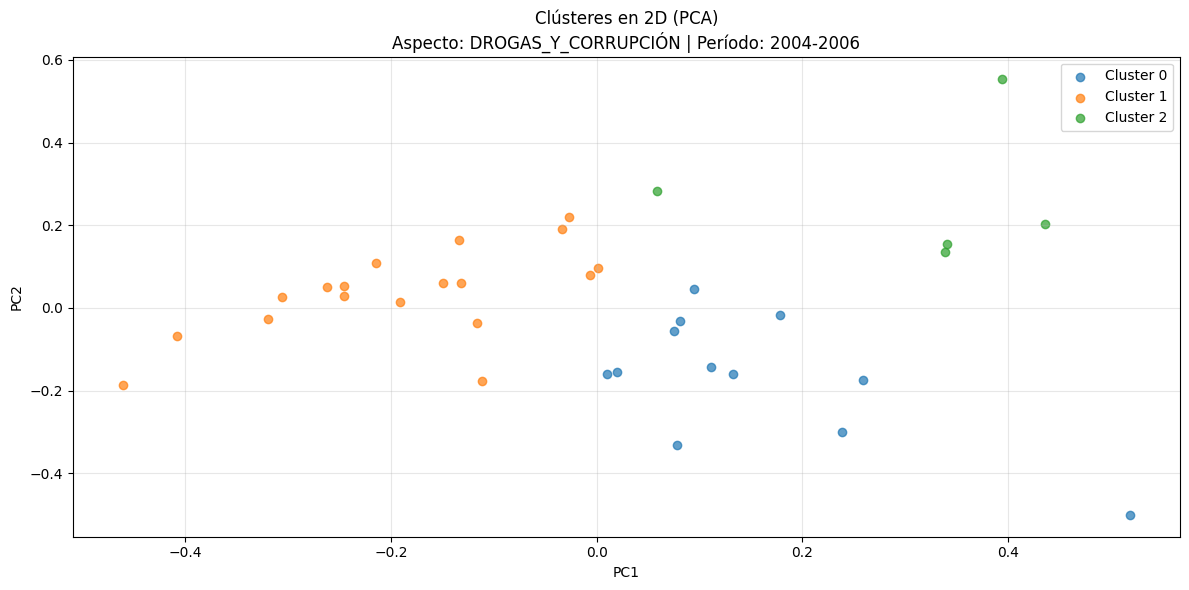


Procesando período: 2007-2009

Países con más de una elección en el período:

Iceland:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
312,2007,Iceland,0.0,0.0,0.0,1.109944,0.795594,0.261244,2.70176,1.561872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313,2009,Iceland,0.0,0.0,0.0,0.000000,0.309832,0.000000,1.12843,3.936932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.0000
per102: 0.0000
per103: 0.0000
per104: 0.5550
per105: 0.5527
per106: 0.1306
per107: 1.9151
per108: 2.7494
per109: 0.3691
per110: 0.5664
per201: 0.9198
per202: 5.0082
per203: 1.1869
per204: 0.0000
per301: 0.5695
per302: 0.0000
per303: 2.8718
per304: 0.8161
per305: 2.3006
per401: 2.2698
per402: 5.4269
per403: 1.2681
per404: 0.6707
per405: 0.2180
per406: 0.0000
per407: 0.3011
per408: 7.8831
per409: 0.7443
per410: 9.3636
per411: 4.2492
per412: 0.1671
per413: 0.8050
per414: 2.7635
per415: 0.0000
per416: 0.9750
per501: 4.7535
per502: 1.3687
per503: 9.9766
per504: 9.2629
per505: 0.2508
per506: 3.8975
per507: 0.1178
per601: 1.5697
per602: 0.0000
per603: 0.4612
per604: 0.0000
per605: 2.4831
per606: 1.9827
per607: 0.4351
per608: 0.1652
per701: 1.3104
per702: 0.0000
per703: 1.7731
per704: 0.1549
per705: 0.8640
per706: 1.4107
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
31,2007,Serbia,0.283115,0.000000,0.301456,0.283115,0.018841,0.067745,0.947593,1.402967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,2008,Serbia,0.683723,0.603859,2.290510,2.001043,0.033981,0.142145,1.195733,1.979848,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.4834
per102: 0.3019
per103: 1.2960
per104: 1.1421
per105: 0.0264
per106: 0.1049
per107: 1.0717
per108: 1.6914
per109: 0.4476
per110: 1.0868
per201: 0.7445
per202: 2.7785
per203: 0.5429
per204: 0.0267
per301: 0.8875
per302: 0.0000
per303: 2.5002
per304: 6.6198
per305: 5.6970
per401: 1.2004
per402: 4.9855
per403: 1.2285
per404: 0.1847
per405: 0.0528
per406: 0.8479
per407: 0.1143
per408: 0.9592
per409: 0.0000
per410: 9.1344
per411: 6.6651
per412: 0.6771
per413: 1.3232
per414: 5.0318
per415: 0.0000
per416: 0.2549
per501: 1.8578
per502: 1.5116
per503: 2.3877
per504: 8.4710
per505: 0.0000
per506: 1.9285
per507: 0.0138
per601: 3.6407
per602: 1.0705
per603: 0.0063
per604: 0.0316
per605: 1.6471
per606: 1.1337
per607: 0.6457
per608: 0.0000
per701: 2.8661
per702: 0.0000
per703: 6.4245
per704: 0.0307
per705: 1.1567
per706: 4.0128
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,2007,Argentina,0.000000,0.000000,0.026193,0.440505,0.104523,0.673115,3.510143,1.155439,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
1,2007,Armenia,0.632548,0.085364,0.000000,3.952777,0.047049,0.141347,2.714306,0.752499,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
2,2007,Australia,0.000000,0.000000,0.000000,1.947871,0.500508,0.060981,1.569552,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
3,2008,Austria,0.000000,0.000000,0.000000,1.148020,0.410887,0.168594,2.544043,4.152601,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
4,2009,Bolivia,0.069921,0.142685,0.495417,0.247366,0.000000,0.216123,1.235030,0.410512,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
5,2009,Bulgaria,0.180294,0.000000,0.000000,1.654966,0.010272,0.000000,1.141401,1.504085,...,0.000000,0.0,0.574802,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
6,2008,Canada,0.319614,0.092275,0.013218,1.479106,0.284984,0.486805,2.359334,0.100991,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
7,2009,Chile,0.005651,0.000000,0.174377,0.897141,0.376400,0.029600,1.546047,0.789124,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
8,2007,Denmark,0.000000,0.000000,0.000000,0.086583,0.342542,0.007225,1.532123,0.901818,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
9,2009,Ecuador,0.113477,0.000000,2.429924,0.000000,0.000000,0.169648,0.615328,1.176980,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


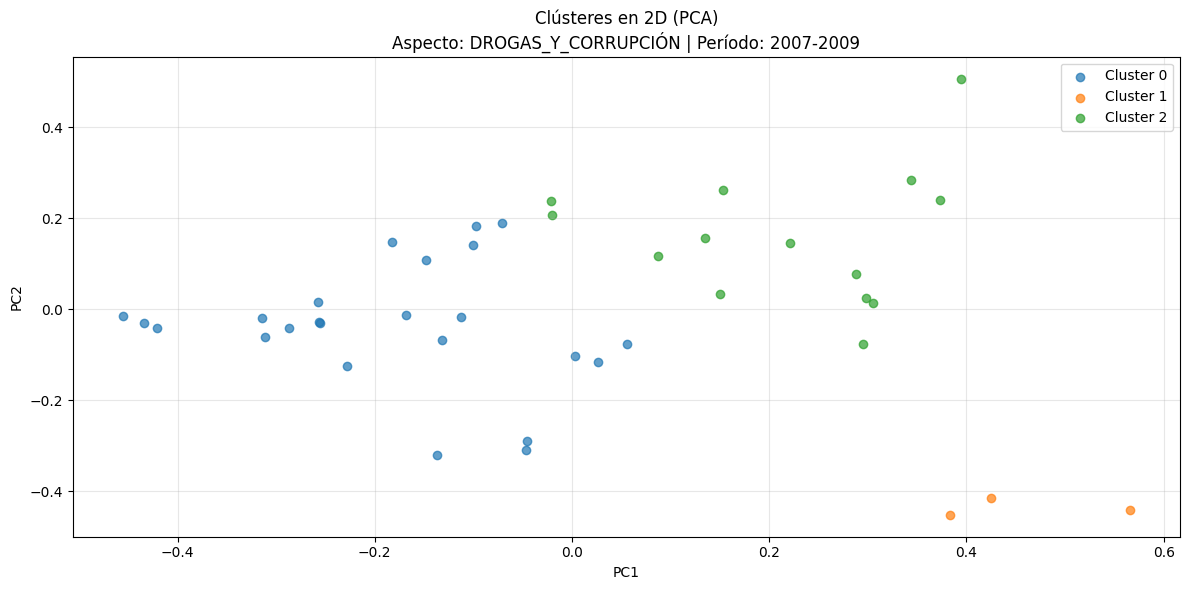


Procesando período: 2010-2012

Países con más de una elección en el período:

Latvia:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
391,2010,Latvia,0.000000,0.0,0.286550,2.089050,0.0,0.344099,2.348288,1.110074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,2011,Latvia,0.209372,0.0,0.578428,1.428032,0.0,0.000000,1.436742,2.774272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.1047
per102: 0.0000
per103: 0.4325
per104: 1.7585
per105: 0.0000
per106: 0.1720
per107: 1.8925
per108: 1.9422
per109: 0.0000
per110: 0.3675
per201: 0.4150
per202: 1.9466
per203: 0.7350
per204: 0.0000
per301: 2.6623
per302: 0.0000
per303: 3.9014
per304: 2.3901
per305: 6.0351
per401: 0.0000
per402: 6.4152
per403: 1.6538
per404: 0.0000
per405: 0.0000
per406: 0.5161
per407: 0.0000
per408: 0.9878
per409: 0.3465
per410: 5.1528
per411: 1.6519
per412: 0.0000
per413: 0.0000
per414: 1.3102
per415: 0.0000
per416: 0.0000
per501: 2.5596
per502: 3.3552
per503: 5.5119
per504: 10.0969
per505: 0.0000
per506: 6.6186
per507: 0.0000
per601: 12.5708
per602: 0.0000
per603: 2.4785
per604: 0.0000
per605: 2.3317
per606: 1.8937
per607: 2.1604
per608: 0.5054
per701: 1.9479
per702: 0.0000
per703: 2.2420
per704: 0.5788
per705: 0.0000
per706: 1.0607
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023:

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
23,2010,Netherlands,0.024776,0.000862,0.000000,0.875348,0.761189,0.098426,3.920728,1.600921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,2012,Netherlands,0.045504,0.000000,0.003503,0.698591,0.368286,0.023846,2.779138,2.496754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.0351
per102: 0.0004
per103: 0.0018
per104: 0.7870
per105: 0.5647
per106: 0.0611
per107: 3.3499
per108: 2.0488
per109: 0.3369
per110: 2.1373
per201: 4.0752
per202: 2.1620
per203: 0.0614
per204: 0.0000
per301: 1.5446
per302: 0.2741
per303: 6.2097
per304: 0.3510
per305: 4.0822
per401: 3.1866
per402: 0.9551
per403: 2.8821
per404: 0.3339
per405: 0.2305
per406: 0.0257
per407: 0.2222
per408: 3.2372
per409: 0.2746
per410: 0.9194
per411: 3.7318
per412: 0.1661
per413: 0.6368
per414: 1.9881
per415: 0.0000
per416: 4.2010
per501: 3.9893
per502: 1.8062
per503: 5.7104
per504: 4.4940
per505: 1.8888
per506: 6.0306
per507: 0.0357
per601: 1.0258
per602: 0.0064
per603: 1.4369
per604: 0.4196
per605: 7.3777
per606: 2.6877
per607: 0.9579
per608: 2.9842
per701: 2.3419
per702: 0.0000
per703: 0.6698
per704: 0.8184
per705: 2.0895
per706: 1.4988
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
30,2010,Slovakia,0.464361,0.00971,0.000000,0.968438,0.122745,0.118873,1.478551,5.768425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,2012,Slovakia,0.023199,0.00000,0.024929,1.328009,0.028440,0.247114,2.170049,4.608597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.2438
per102: 0.0049
per103: 0.0125
per104: 1.1482
per105: 0.0756
per106: 0.1830
per107: 1.8243
per108: 5.1885
per109: 0.2910
per110: 0.8454
per201: 0.9583
per202: 0.8025
per203: 0.1963
per204: 0.1289
per301: 0.9417
per302: 0.0827
per303: 4.7223
per304: 2.0266
per305: 2.6778
per401: 1.4221
per402: 4.1855
per403: 2.2027
per404: 1.6517
per405: 0.5055
per406: 0.2642
per407: 0.0413
per408: 1.9107
per409: 0.1332
per410: 0.6839
per411: 7.0074
per412: 0.3250
per413: 0.1706
per414: 2.4011
per415: 0.0000
per416: 2.3723
per501: 3.0337
per502: 2.7461
per503: 5.4285
per504: 8.4953
per505: 3.3841
per506: 7.2534
per507: 1.1096
per601: 0.9999
per602: 0.0041
per603: 1.5644
per604: 0.8090
per605: 7.6056
per606: 0.9617
per607: 0.7490
per608: 0.1309
per701: 3.2071
per702: 0.2304
per703: 1.8251
per704: 0.8358
per705: 0.1533
per706: 1.4873
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,2011,Argentina,0.000000,0.000000,1.676117,0.060628,0.000000,1.569691,3.618780,4.707317,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,2012,Armenia,0.850569,0.177561,0.000000,3.841228,0.141487,0.035444,0.642249,1.006854,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,2010,Australia,1.470758,0.000000,0.060231,0.717799,0.171998,0.156712,3.895066,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,2010,Belgium,0.320104,0.032076,0.000000,0.592083,0.362014,0.133656,2.396315,1.775054,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,2010,Bosnia-Herzegovina,1.132900,0.114260,0.102075,1.121042,0.964857,0.659185,1.247413,2.666885,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
5,2010,Brazil,0.011216,0.000000,1.112648,0.607055,0.000000,1.087955,2.045439,0.438889,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,2011,Canada,0.402567,0.000000,0.000000,2.956539,0.796322,0.377550,1.643699,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7,2010,Colombia,0.439662,0.000000,0.366611,0.584469,0.104019,0.184161,3.021345,0.594406,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
8,2010,Costa Rica,0.230805,0.000000,0.227840,0.080553,0.123894,0.511692,1.357479,0.091947,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
9,2011,Cyprus,0.126022,2.416041,0.133206,0.838510,0.128424,0.128424,1.703411,1.155240,...,0.00000,6.306061,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


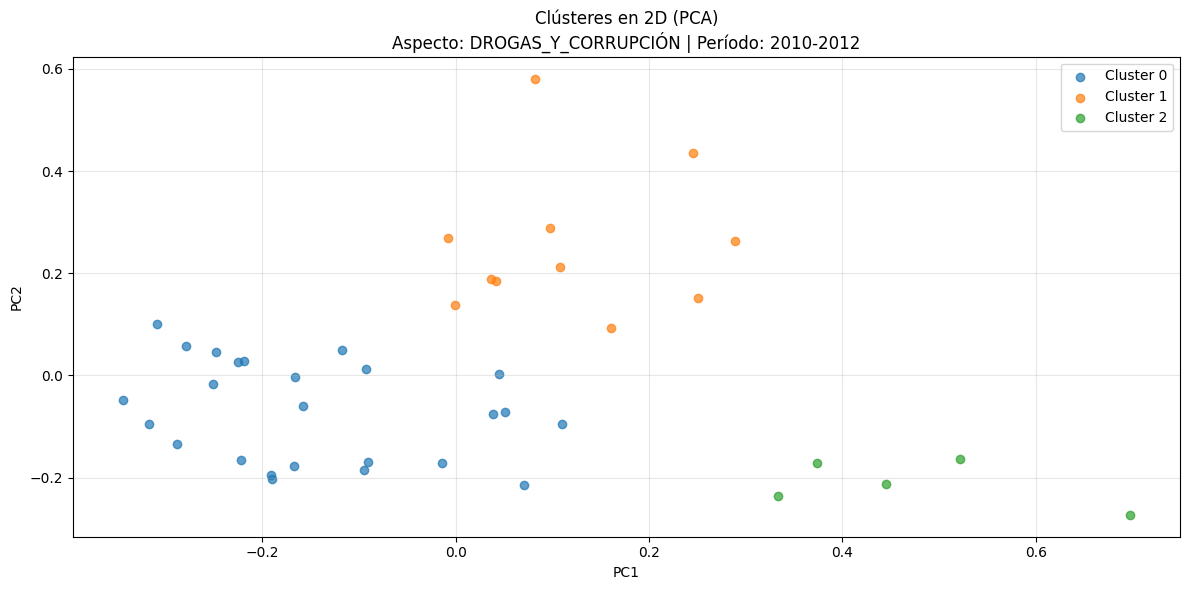


Procesando período: 2013-2015

Países con más de una elección en el período:

Argentina:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
8,2013,Argentina,0.0,0.0,3.575799,0.00000,0.0,0.000000,0.369729,2.754000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2015,Argentina,0.0,0.0,2.193444,1.47008,0.0,0.329077,3.713293,1.574236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.0000
per102: 0.0000
per103: 2.8846
per104: 0.7350
per105: 0.0000
per106: 0.1645
per107: 2.0415
per108: 2.1641
per109: 0.0000
per110: 0.0000
per201: 3.9959
per202: 8.6166
per203: 1.0746
per204: 0.0000
per301: 1.3788
per302: 0.0000
per303: 1.6657
per304: 2.9319
per305: 7.2680
per401: 0.2387
per402: 2.2952
per403: 1.1036
per404: 0.4060
per405: 0.0961
per406: 0.3291
per407: 0.2387
per408: 0.5017
per409: 1.1865
per410: 1.8208
per411: 6.3486
per412: 0.5961
per413: 0.9872
per414: 2.3081
per415: 0.0000
per416: 1.0422
per501: 0.4619
per502: 0.6390
per503: 5.5513
per504: 10.5389
per505: 0.1069
per506: 6.7678
per507: 0.0357
per601: 2.0754
per602: 0.0000
per603: 0.2138
per604: 0.0000
per605: 4.7465
per606: 1.8899
per607: 0.2397
per608: 0.0000
per701: 4.9360
per702: 0.0000
per703: 1.7338
per704: 0.0000
per705: 1.7879
per706: 1.7469
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,2013,Australia,1.454681,0.000000,0.000000,0.901525,0.000000,0.000000,2.943830,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013,Austria,0.021851,0.000000,0.034318,1.095127,0.161511,0.393675,1.873533,1.261934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014,Belgium,0.120782,0.000000,0.037071,0.928156,0.143896,0.075668,2.225982,1.827997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014,Bolivia,0.000000,0.086730,2.322482,1.062232,0.032262,0.064781,1.209891,0.216291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,Bosnia-Herzegovina,0.917736,0.000000,0.074423,0.168539,0.060279,0.481705,1.367551,1.942751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2014,Brazil,0.039303,0.000000,0.079465,0.393028,0.000000,0.153625,1.353445,0.276410,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2013,Bulgaria,0.000000,0.000000,0.615690,1.767122,0.156824,0.056741,1.605320,1.330373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2015,Canada,0.620733,0.020902,0.000000,3.542501,0.156811,0.312564,3.049638,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2013,Chile,0.207215,0.000000,0.000000,0.966870,0.330345,0.055490,0.421749,1.206564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2014,Colombia,0.024478,0.209396,0.160602,0.666006,0.097872,1.803240,2.036689,0.255107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


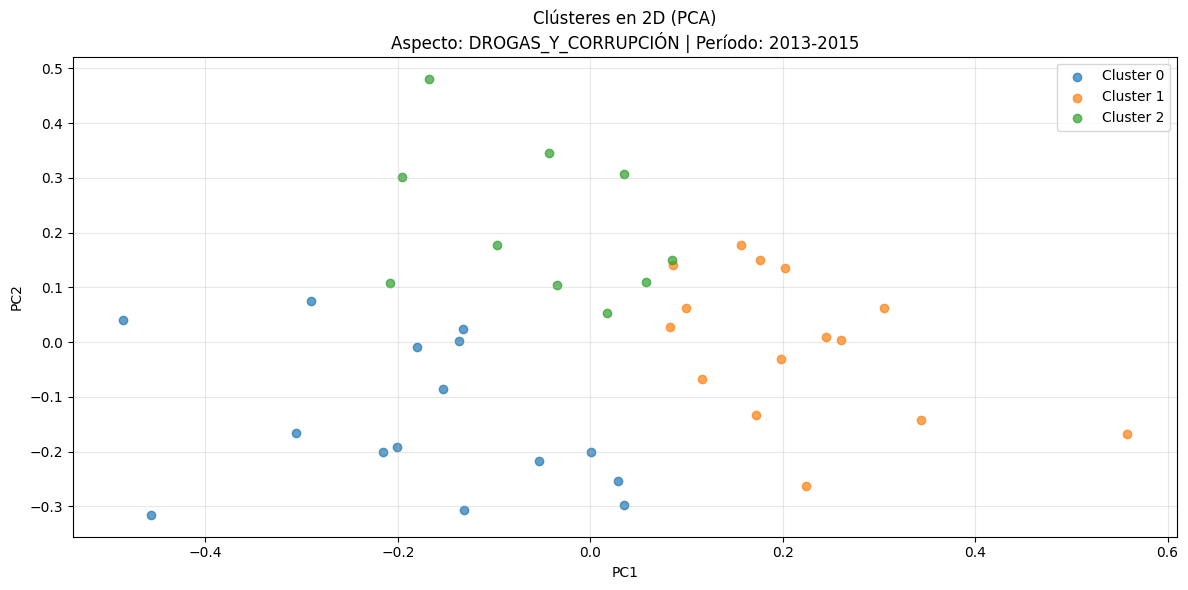


Procesando período: 2016-2018

Países con más de una elección en el período:

Armenia:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
16,2017,Armenia,1.395307,0.653802,0.0,7.839322,0.0,0.130390,0.973000,0.260779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,2018,Armenia,0.756948,0.529989,0.0,7.686817,0.0,0.952345,1.439193,0.448766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 1.0761
per102: 0.5919
per103: 0.0000
per104: 7.7631
per105: 0.0000
per106: 0.5414
per107: 1.2061
per108: 0.3548
per109: 0.0408
per110: 0.0000
per201: 1.3026
per202: 6.6082
per203: 0.1304
per204: 0.0000
per301: 0.0522
per302: 0.3912
per303: 7.5831
per304: 3.2846
per305: 0.9312
per401: 0.0000
per402: 9.4188
per403: 5.4744
per404: 0.1854
per405: 0.0000
per406: 0.1012
per407: 0.3912
per408: 0.2012
per409: 0.0000
per410: 1.8696
per411: 5.7046
per412: 1.0631
per413: 0.0522
per414: 0.8108
per415: 0.0000
per416: 0.7379
per501: 3.1058
per502: 3.5437
per503: 1.2377
per504: 6.3717
per505: 0.0000
per506: 8.4075
per507: 0.0000
per601: 3.9233
per602: 0.0000
per603: 0.3636
per604: 0.0000
per605: 2.1327
per606: 0.2861
per607: 0.0301
per608: 0.0000
per701: 6.2323
per702: 0.0000
per703: 4.9332
per704: 0.1669
per705: 0.2079
per706: 0.4508
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023: 0

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,2016,Australia,0.000000,0.000000,0.000000,2.414699,0.021005,0.112728,1.539566,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017,Austria,0.000000,0.000000,0.000000,2.061536,0.041580,0.079540,1.346257,1.216543,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018,Brazil,0.057251,0.000000,0.766505,1.956240,0.014279,0.196115,0.699719,0.593631,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017,Bulgaria,1.085614,0.269283,0.269283,4.270000,0.000000,0.131728,2.191860,1.651838,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017,Chile,0.120377,0.007759,0.032650,0.457728,0.192404,0.146080,0.654128,0.359964,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016,Cyprus,0.176350,3.521798,0.533179,0.873432,0.179155,0.632428,1.208043,0.721641,...,0.0,5.119887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2017,Czech Republic,0.013354,0.000000,0.065485,4.583272,0.267121,0.380970,1.822157,1.217937,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2016,Dominican Republic,0.654300,0.000000,0.000000,0.037662,0.000000,0.037662,1.739357,0.167512,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2017,France,0.000000,0.000000,0.106288,1.635853,0.104665,0.285786,0.822249,2.693585,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2016,Georgia,1.174489,1.974862,0.000000,4.797921,0.647924,2.666842,2.623188,3.853817,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


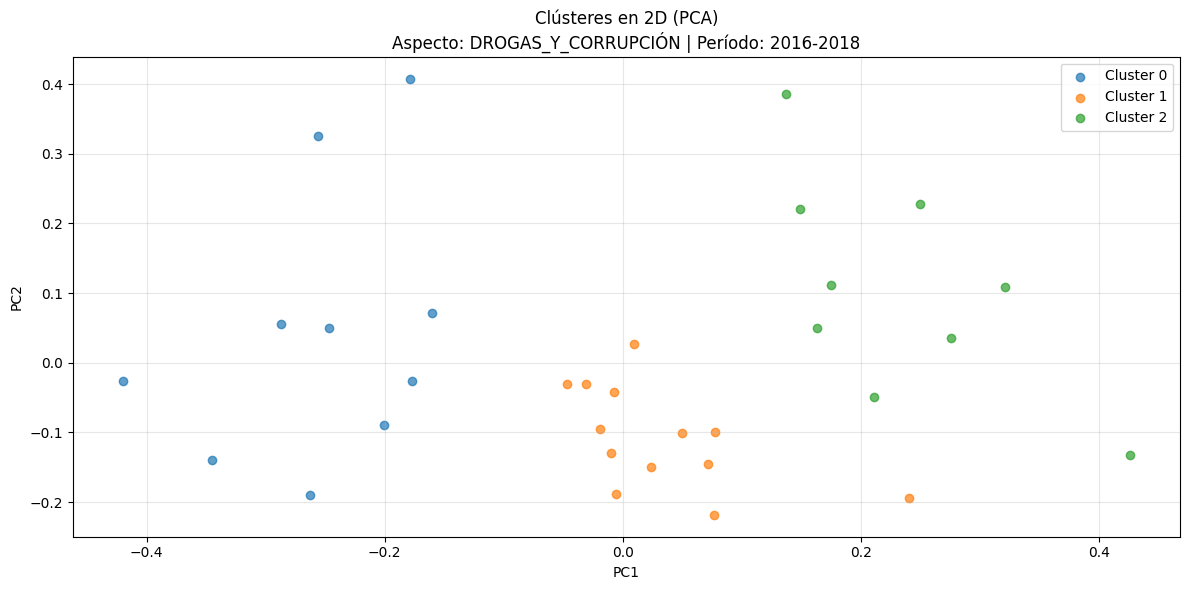


Procesando período: 2019-2022

Países con más de una elección en el período:

Australia:
Registros originales (2):


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
47,2019,Australia,0.567388,0.012864,0.000000,2.524464,0.154969,0.09146,0.434446,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,2022,Australia,0.851622,0.019521,0.148398,5.672560,0.205239,0.04450,1.388719,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Valores promediados:
per101: 0.7095
per102: 0.0162
per103: 0.0742
per104: 4.0985
per105: 0.1801
per106: 0.0680
per107: 0.9116
per108: 0.0000
per109: 0.0159
per110: 0.0027
per201: 0.8789
per202: 0.9557
per203: 0.0073
per204: 0.0320
per301: 0.7172
per302: 0.0251
per303: 0.7920
per304: 1.7457
per305: 2.0283
per401: 0.7749
per402: 4.4410
per403: 6.4476
per404: 0.2208
per405: 0.2484
per406: 0.2643
per407: 0.1670
per408: 0.0834
per409: 1.3267
per410: 3.2331
per411: 11.0310
per412: 0.5768
per413: 0.3024
per414: 0.3670
per415: 0.0000
per416: 3.1695
per501: 5.9203
per502: 1.6639
per503: 5.8581
per504: 12.9984
per505: 0.0419
per506: 2.5120
per507: 0.0000
per601: 0.9467
per602: 0.7725
per603: 0.2139
per604: 0.0719
per605: 3.7608
per606: 0.4210
per607: 3.4459
per608: 0.0133
per701: 5.6262
per702: 0.2350
per703: 8.3330
per704: 0.0550
per705: 0.0541
per706: 0.8946
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
per1023:

,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,2019,Argentina,0.000000,0.000000,1.478898,1.518659,0.113644,0.594088,3.418984,0.688078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,Armenia,1.877354,0.369588,0.000000,6.930662,0.000000,0.133881,2.303442,0.384132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,Austria,0.000000,0.000000,0.000000,1.300189,0.114756,0.201104,2.206878,2.089282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019,Belgium,0.062118,0.000000,0.087621,1.067569,0.258610,0.136532,1.898790,1.352571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022,Brazil,0.000000,0.000000,0.463649,0.690862,0.000000,0.163617,1.961420,0.375121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2019,Canada,0.035967,0.192398,0.000000,2.040502,0.072144,0.405559,1.711922,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2021,Chile,0.038239,0.015586,0.059179,0.688266,0.217654,0.086899,0.766963,0.170824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2019,Denmark,0.000000,0.000000,0.145950,1.030195,0.173018,0.078527,3.820138,2.600006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2019,Estonia,0.018787,0.243498,0.036218,8.179130,0.000000,0.115294,1.446012,1.378032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2019,Finland,0.303665,0.000000,0.000000,1.816082,0.301268,0.207669,2.111900,0.958192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


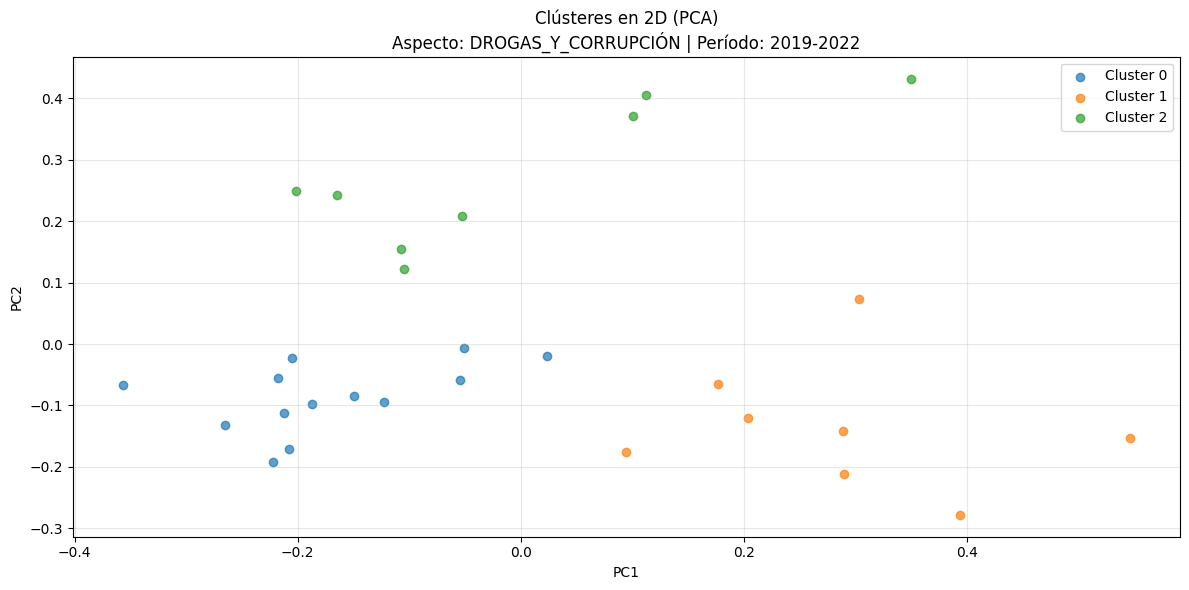

grafo_coincidencias_filtrado.html
Grafo guardado como 'grafo_coincidencias_filtrado.html'. Ábrelo para visualizar.
Leyenda añadida al archivo HTML.


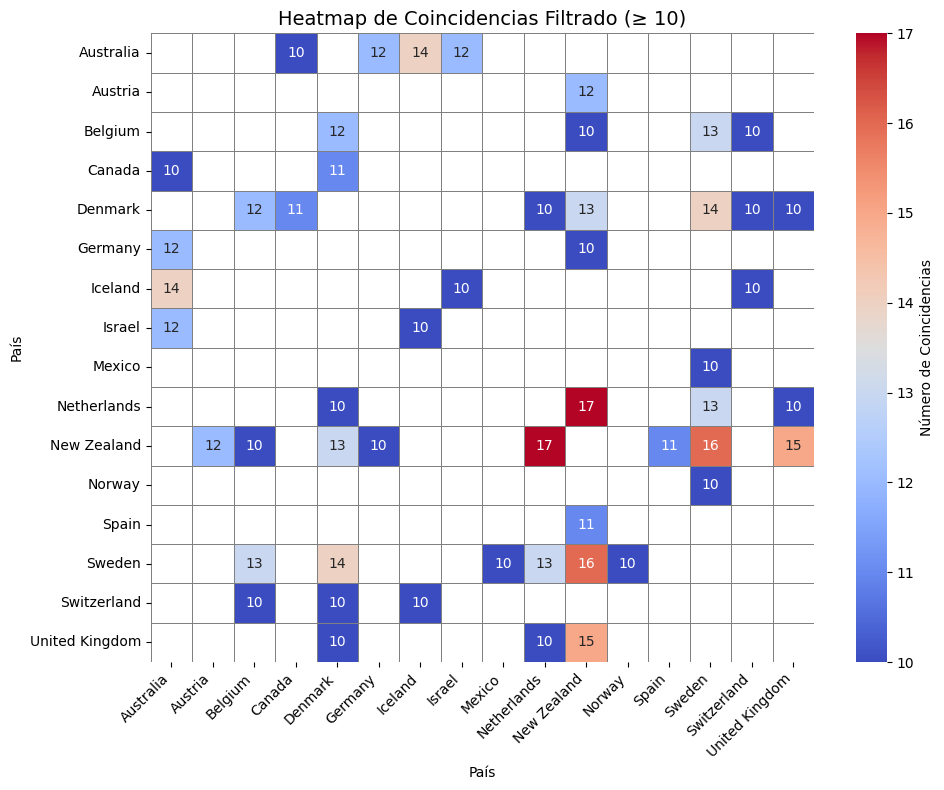

In [24]:
# Definir períodos múltiples para el análisis
periodos = [(1949, 1951),(1952, 1954),(1955, 1957),(1958, 1960),(1961, 1963),(1964, 1966), (1967, 1969), (1970, 1972), (1973, 1975), (1976, 1978), (1979, 1981), (1982, 1984), (1985, 1987), (1988, 1990), (1991, 1993), (1994, 1996), (1997, 2000), (2001, 2003), (2004, 2006), (2007, 2009), (2010, 2012), (2013, 2015), (2016, 2018), (2019, 2022)]
aspecto_filtro = 'DROGAS_Y_CORRUPCIÓN'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3', 'var_4', 'var_5']].dropna().values.flatten()

# Diccionario para almacenar resultados por período
resultados_temporales = {}

for desde, hasta in periodos:
    print(f"\nProcesando período: {desde}-{hasta}")
    
    # Preprocesar y normalizar datos
    df_periodo = preprocesar_periodo(df, desde, hasta)
    df_filtered = filtrar_y_normalizar(df_periodo, variables)
    
    # Ejecutar PCA y K-MEANS
    df_pca, pca, kmeans = ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta)
    
    # Almacenar los países en cada clúster
    clusters = {}
    for cluster in df_pca['cluster'].unique():
        clusters[cluster] = df_pca[df_pca['cluster'] == cluster]['countryname'].unique()
    resultados_temporales[f"{desde}-{hasta}"] = clusters

# Construir y visualizar la matriz de coincidencias
coincidence_matrix = construir_matriz_coincidencias(resultados_temporales)
#grafo_coincidencias(coincidence_matrix)

#paises_seleccionados = ["Armenia", "Finland", "United States", "Australia", "Georgia"]
#paises_seleccionados = ["Armenia", "United States"]
#graficar_trayectorias_seleccion(resultados_temporales, paises_seleccionados)
grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10)

# Ejecutar heatmap filtrando según un umbral
heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm")

In [ ]:
coincidence_matrix